# Ejercicio

## $\mathtt{Sobre\;Logitech}$

***Logitech International S.A***. es una empresa suiza-estadounidense que se especializa en la fabricación de productos periféricos para computadoras y tecnología. Fundada en 1981, es conocida por desarrollar ratones, teclados, cámaras web, auriculares y dispositivos de juego. Logitech ha sido pionera en el diseño innovador de hardware, enfocándose en la calidad y funcionalidad de sus productos, y ha expandido su gama de productos a soluciones de videoconferencia, accesorios para consolas de videojuegos y dispositivos para el hogar inteligente. *Su presencia global la posiciona como una marca reconocida en el sector tecnológico*.

## $\mathtt{Desarrollo}$

### $\mathtt{Librerías}$

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, plot, xlabel, ylabel, legend, close, subplots, title
import plotly.graph_objects as go

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa import seasonal
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from scipy.stats import shapiro

In [23]:
sns.set_theme()
sns.set_context("paper")

### $\mathtt{Importar\;datos}$

In [24]:
ticker = 'LOGI'
data = yf.download(ticker, start="2014-01-01", end="2024-09-14") 
data = pd.DataFrame(data)

[*********************100%***********************]  1 of 1 completed


Aquí se encuentra información histórica sobre el precio de la acción de **Logitech International S.A.** de 2693 días desde el primero de enero del 2014 hasta el 13 de septiembre del 2024. Los datos incluyen el precio de apertura, precio más alto y más bajo del día, precio de cierre y volumen de operaciones.

### $\mathtt{Análisis\;exploratorio}$

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2693 entries, 2014-01-02 to 2024-09-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2693 non-null   float64
 1   High       2693 non-null   float64
 2   Low        2693 non-null   float64
 3   Close      2693 non-null   float64
 4   Adj Close  2693 non-null   float64
 5   Volume     2693 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 147.3 KB


In [26]:
print(data.shape)
data.head()

(2693, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,13.51,13.54,13.12,13.35,10.990413,431500
2014-01-03,13.45,13.48,13.32,13.40,11.031575,289200
2014-01-06,13.74,13.80,13.58,13.59,11.187994,460600
2014-01-07,14.04,14.22,13.96,14.05,11.566690,760900
2014-01-08,14.19,14.29,13.94,14.01,11.533759,983700


In [27]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2693.000000,2693.000000,2693.000000,2693.000000,2693.000000,2.693000e+03
mean,48.469896,48.937308,48.011170,48.492551,46.149355,5.284367e+05
std,29.614433,29.926410,29.285854,29.624649,29.380180,4.917642e+05
min,11.210000,11.530000,11.200000,11.510000,9.636723,4.650000e+04
25%,21.559999,21.740000,21.480000,21.639999,19.302317,2.605000e+05
50%,40.889999,41.139999,40.619999,40.900002,38.433517,4.053000e+05
75%,70.500000,71.309998,69.830002,70.470001,68.260002,6.299000e+05
max,137.990005,140.169998,137.649994,138.699997,132.198685,7.572900e+06


In [28]:
(10**6) * 7.5729

7572900.0

En promedio, durante los 10 años analizados, la acción abrió la jornada en $48.46 y cerró en $48.49, fluctuando entre un mínimo de $48.01 y un máximo de $48.93 a lo largo del día, lo que refleja una estabilidad moderada con baja volatilidad diaria. Además, se negociaron en promedio 528,000 acciones por día, con un mínimo de 46,500 acciones y un máximo 7'572,900, mostrando una considerable variabilidad en el volumen de transacciones, lo que sugiere fluctuaciones en el interés del mercado.

#### $\mathtt{Serie\;original}$

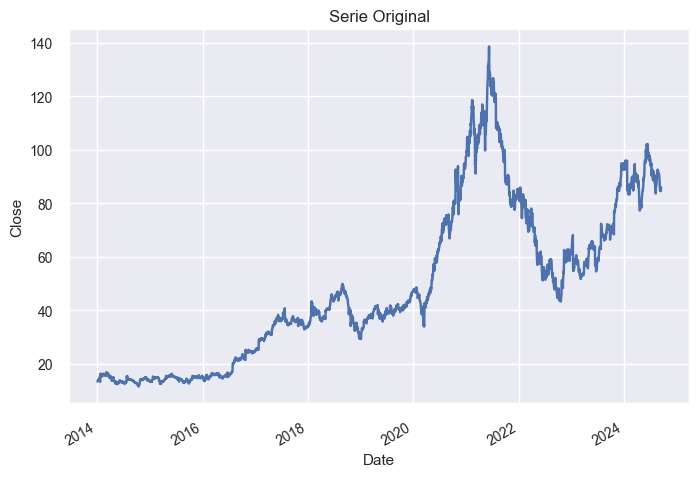

In [29]:
nlag = 40
plt.style.use('seaborn-v0_8-notebook')

data['Close'].plot()
plt.title('Serie Original')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

Se puede notar un aumento en el precio de cierre a lo largo de los años, entre 2020 y finales del 2021 este crecimiento fue más notorio. Hubo una gran disminución en el precio de ajustado de cierre desde finales del 2021 hasta mediados del 2022. No parece ser estacionaria. 



#### $\mathtt{Autocorrelación}$

Acá, usamos los lags para medir la autocorrelación, que es la correlación de la serie de tiempo con una versión retrasada de sí misma, para identificar patrones y posibles dependencias temporales en los datos.

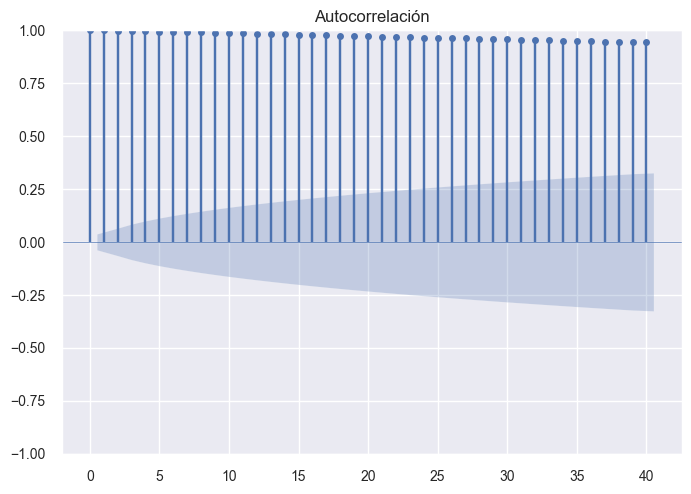

In [30]:
plot_acf(data['Close'], lags=nlag, linewidth=0.5)  # Autocorrelación
plt.title('Autocorrelación')
plt.show()

Al revisar la autocorrelación se nota una fuerte correlación temporal entre los valores del precio de cierre en diferentes momentos, lo que sugiere un patrón de dependencia a largo plazo o incluso la presencia de una tendencia en los datos. Además, dado que todos estos valores recaen bajo la zona sombreada, los valores de la serie están correlacionados con los valores de esos periodos anteriores de manera significativa.


#### $\mathtt{Autocorrelación\;parcial}$
La gráfica de autocorrelación parcial, a diferencia de la grafica de autocorrelación, mide la correlación entre una observación y su lag específico, eliminando el efecto de los lags intermedios.

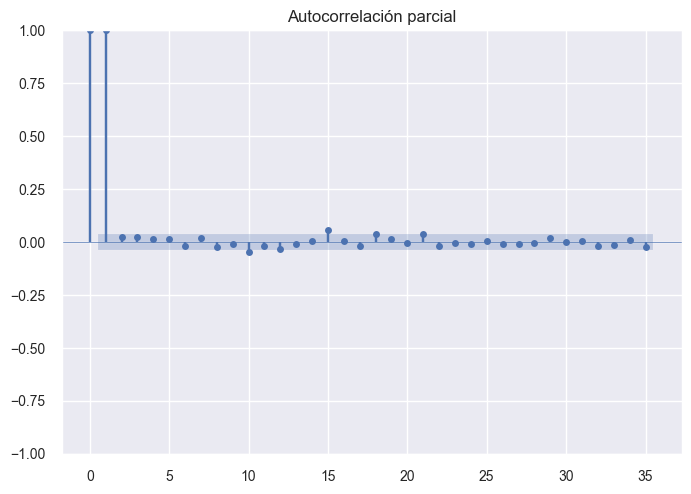

In [31]:
plot_pacf(data['Close'], linewidth = 0.5)
plt.title('Autocorrelación parcial')
plt.show()

Los coeficientes PACF bajan rápidamente hacia 0, indicando que solo los primeros lags tienen una influencia significativa directa sobre los valores actuales. La gran mayoría de las observaciones de los lags no son significativas.

### $\mathtt{Estacionariedad\;por\;método\;analítico\;(Dickey\;Fuller)}$

 **$H_{\theta} : ρ \geq \alpha$** La serie tiene una raíz unitaria y no es estacionaria.

 **$H_{1} : ρ < \alpha$** La serie no tiene una raíz unitaria y es estacionaria.


In [32]:
adf_result = adfuller(data["Close"].tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])


ADF Statistic: -0.962046
p-value: 0.766854


Teniendo en cuenta el valor de ADF, el cual no es un valor tan negativo, sugiere que no es estacionaria. Además, dado que el $𝑝-valor$ de la prueba de Dickey Fuller es $0.766854 > 0.05 = \alpha$, no se rechaza la hipótesis nula, es decir, la serie temporal **no es estacionaria.**

### $\mathtt{Descomposición\;de\;la\;serie}$

La descomposición de series temporales es una técnica que permite comprender los componentes de una serie temporal desglosando los datos en sus partes constituyentes, como la tendencia, la estacionalidad y los residuos.

In [33]:
decompose_model = seasonal.seasonal_decompose(data["Close"].tolist(),
period=30, model='additive')

Text(0.5, 1.0, 'Componente residual del precio de cierre de Logitech')

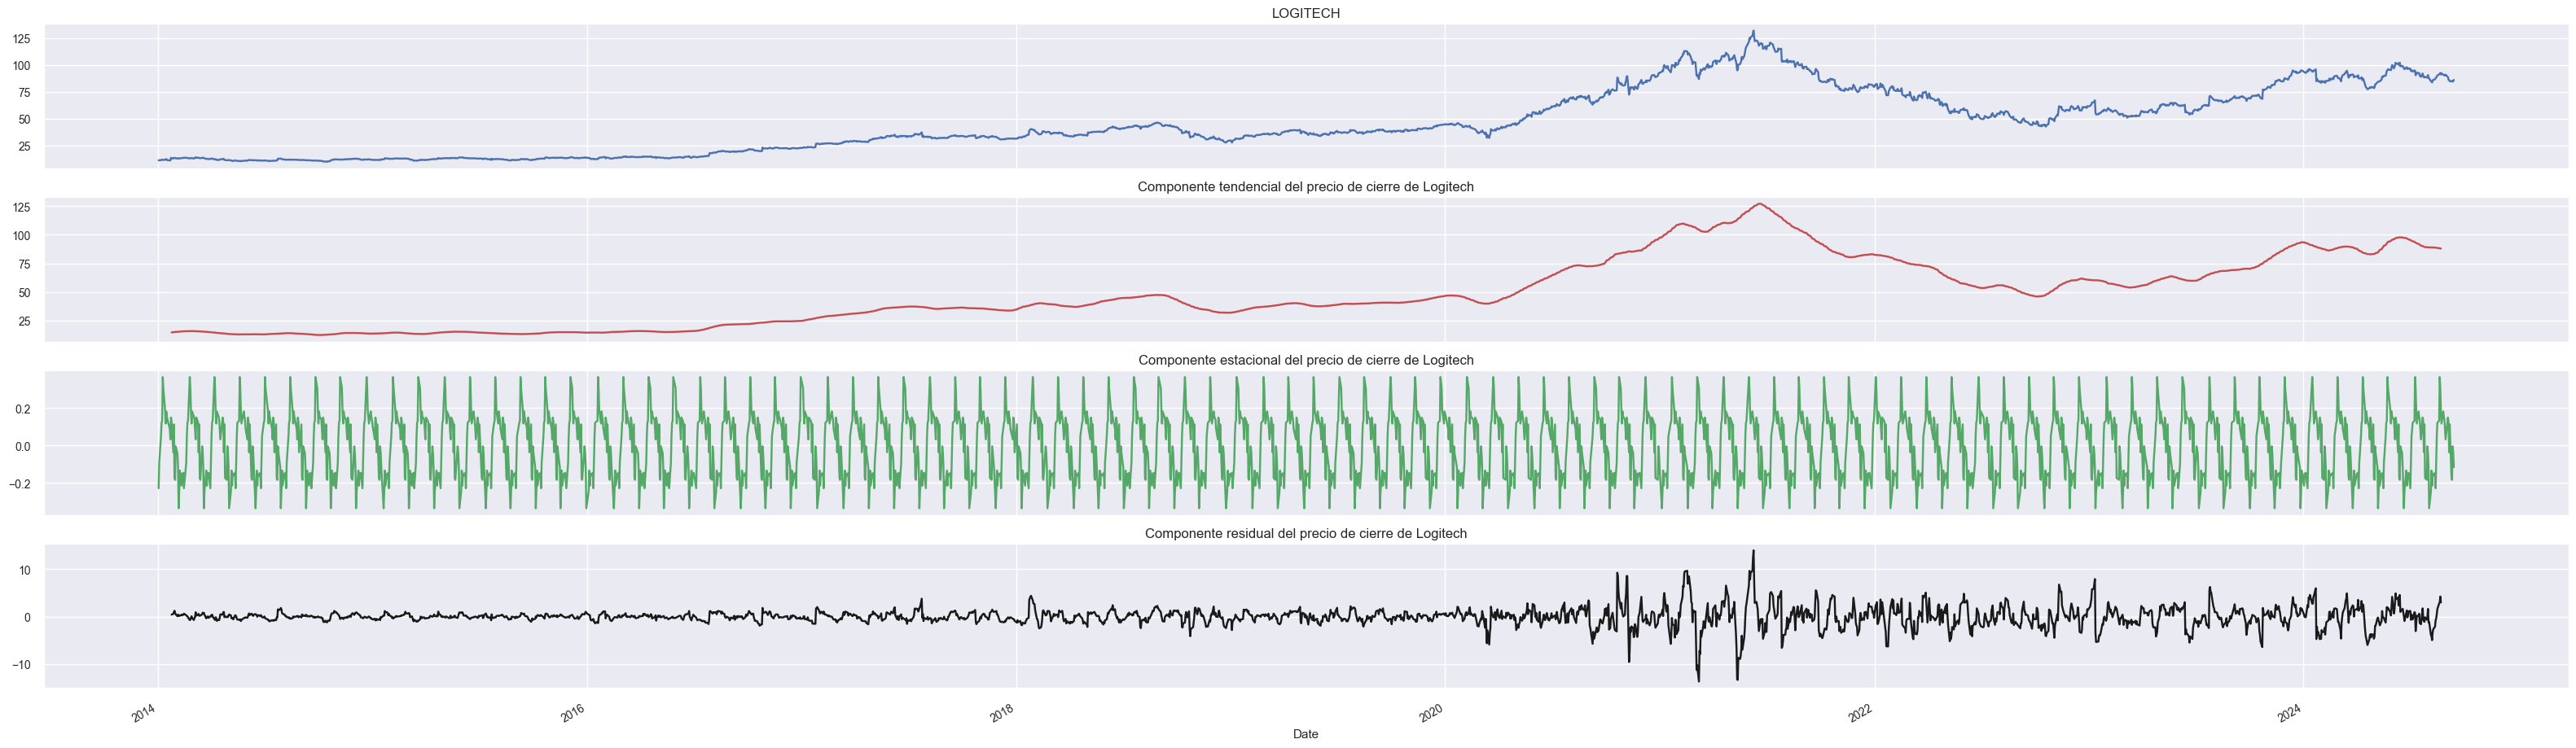

In [34]:
fig, axarr = plt.subplots(4, sharex=True)
fig.set_size_inches(40, 12)

data['Adj Close'].plot(ax=axarr[0], color='b', linestyle='-')
axarr[0].set_title('LOGITECH')

pd.Series(data=decompose_model.trend, index=data.index).plot(color='r',
linestyle='-', ax=axarr[1])
axarr[1].set_title('Componente tendencial del precio de cierre de Logitech')

pd.Series(data=decompose_model.seasonal, index=data.index).plot(color='g',
linestyle='-', ax=axarr[2])
axarr[2].set_title('Componente estacional del precio de cierre de Logitech')

pd.Series(data=decompose_model.resid, index=data.index).plot(color='k',
linestyle='-', ax=axarr[3])
axarr[3].set_title('Componente residual del precio de cierre de Logitech')


$1.\;\mathtt{Componente\;tendencial: }$ este representa el movimiento o la dirección de los datos a largo plazo que puede caracterizarse por un aumento o una disminución gradual o por una estabilidad a lo largo de un período prolongado. Para Logitech, en los últimos 10 años parece haber un tendencia hacia el aumento del precio de cierre a lo largo de los años de manera gradual.

$2.\;\mathtt{Componente\;estacional: }$ este da cuenta de patrones regulares y recurrentes que se manifiestan en intervalos de tiempo fijos. En la gráfica se observa un patrón y amplitud constante en los años. 

$3.\;\mathtt{Componente\;residual: }$ por último, el componente residual o error captura las fluctuaciones aleatorias o *ruido* que no pueden ser explicadas por la tendencia o el componente estacional. Esta no parece tener un patrón según la gráfica.

Verifiquemos ahora la no estacionalidad y normalidad de los residuos de la descomposición.

In [35]:
adf_result = adfuller(decompose_model.resid[np.where(np.isfinite(decompose_model.resid))[0]],autolag='AIC')
print(adf_result[1])

3.09958429416318e-26


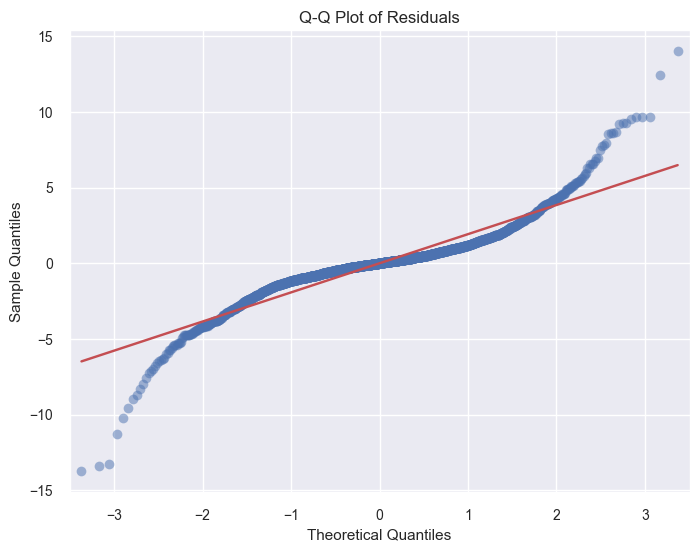

In [36]:
decompose_model = seasonal.seasonal_decompose(data['Close'], period=30, model='additive')

plt.rcParams.update({'figure.figsize': (8, 6)})
fig = sm.qqplot(decompose_model.resid.dropna(), line='s', alpha=0.5, color='b', lw=2)
plt.title('Q-Q Plot of Residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.grid(True)
plt.show()

In [37]:
resid_clean = pd.Series(decompose_model.resid).replace([np.inf, -np.inf], np.nan).dropna()

stat, p = shapiro(resid_clean)

alpha = 0.05
if p > alpha:
    print('Normal')
else:
    print('No normal')

print('Statistics=%.3f, p=%.3f' % (stat, p))

No normal
Statistics=0.874, p=0.000


Donde se encuentra que los residuos no siguen una distribución normal, algo bastante notable en la gráfica QQ de los residuos. Además, aparentemente son estacionarios debido al $p-valor$ tan pequeño obtenido del test de Dickey Fuller para los residuos.

## $\mathtt{Modelo:\;ARIMA}$

El modelo ARIMA (*AutoRegressive Integrated Moving Average*) es una herramienta estadística de gran utilidad para analizar y pronosticar datos de series temporales. Se adapta explícitamente a un conjunto de estructuras estándar en datos de series temporales y, como tal, proporciona un método simple pero potente para realizar pronósticos hábiles de series temporales.

Los parámetros del modelo ARIMA se definen de la siguiente manera:

$-\;p:$ orden de retardo, que representa la cantidad de observaciones de retardo incorporadas en el modelo.$\newline$
$-\;d:$ grado de diferenciación, que indica la cantidad de veces que las observaciones brutas se someten a diferenciación.$\newline$
$-\;q:$ orden de promedio móvil, que indica el tamaño de la ventana de promedio móvil.$\newline$

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

### $\mathtt{Diferenciación}$

La diferenciación puede ayudar a estabilizar la media de una serie temporal eliminando cambios en el nivel de una serie temporal y, por tanto, eliminando (o reduciendo) la tendencia y la estacionalidad.

https://otexts.com/fpp2/stationarity.html

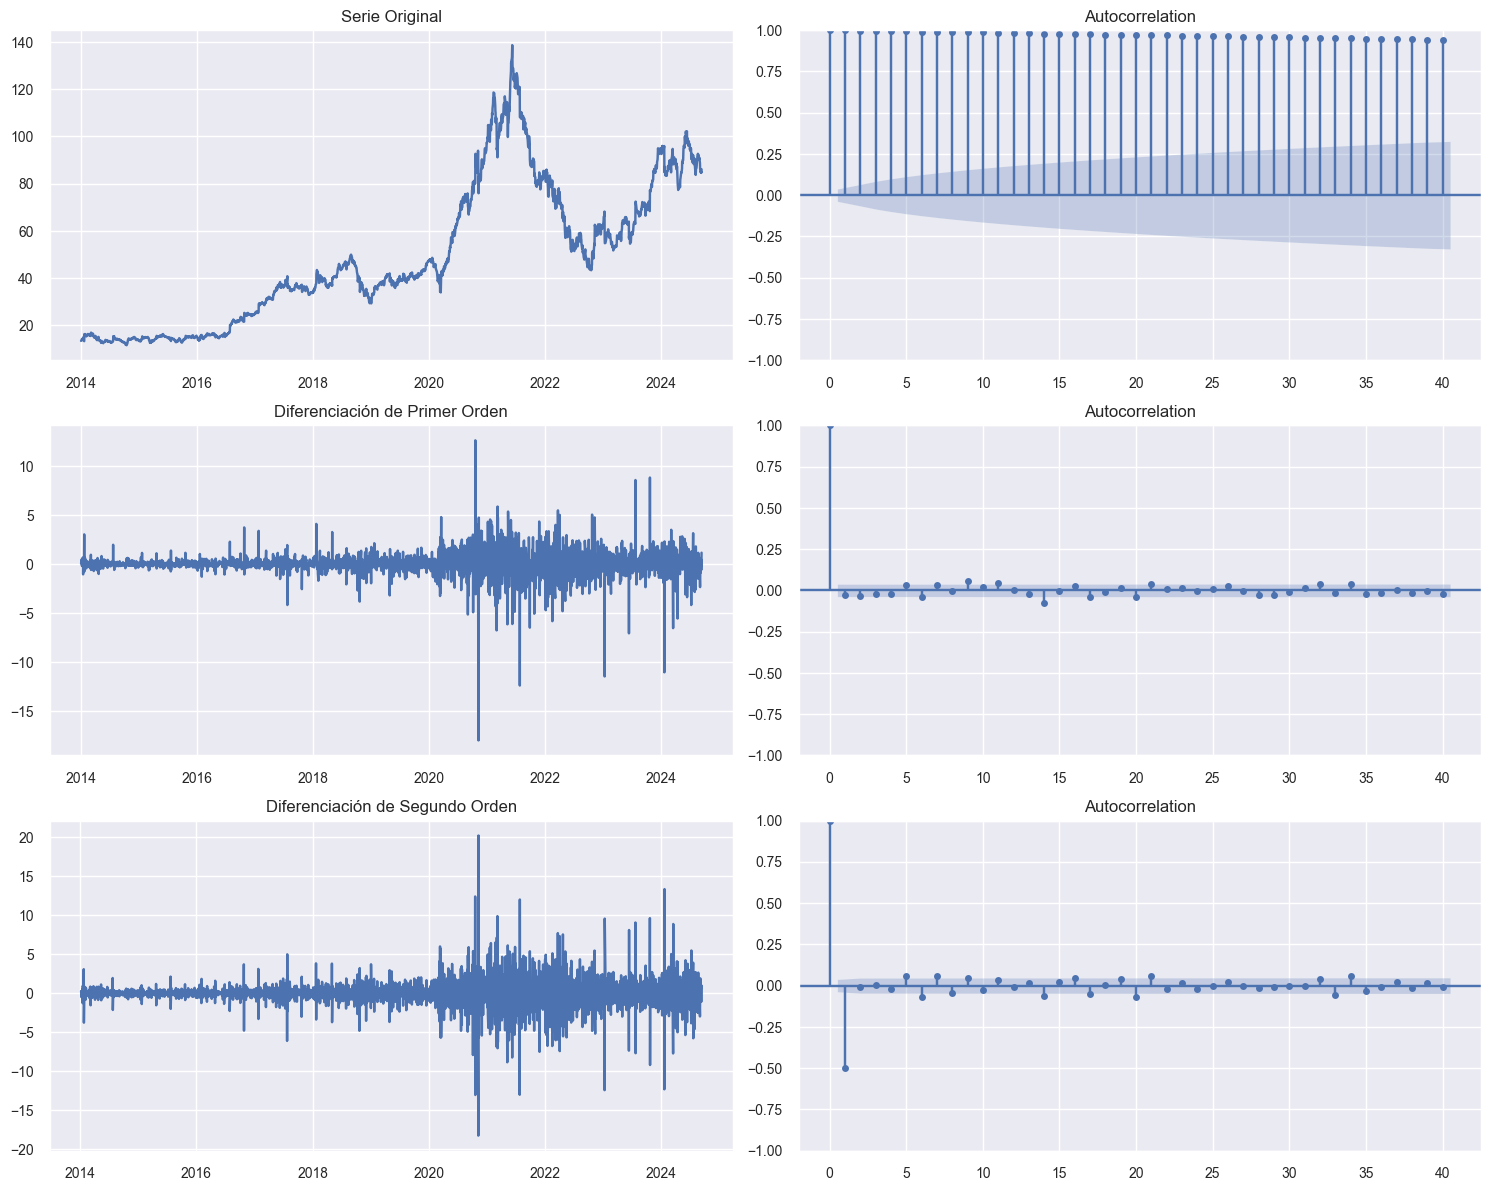

In [38]:
data_reset = data.reset_index()

plt.style.use('seaborn-v0_8-notebook')
plt.rcParams.update({'figure.figsize': (15, 12)})

fig, axes = plt.subplots(3, 2)

axes[0, 0].plot(data_reset['Date'], data_reset['Close'])
axes[0, 0].set_title('Serie Original')
plot_acf(data['Close'], ax=axes[0, 1], lags=40)

axes[1, 0].plot(data_reset['Date'], data_reset['Close'].diff())
axes[1, 0].set_title('Diferenciación de Primer Orden')
plot_acf(data['Close'].diff().dropna(), ax=axes[1, 1], lags=40)

axes[2, 0].plot(data_reset['Date'], data_reset['Close'].diff().diff())
axes[2, 0].set_title('Diferenciación de Segundo Orden')
plot_acf(data['Close'].diff().diff().dropna(), ax=axes[2, 1], lags=40)

plt.tight_layout()
plt.show()

El cambio brusco en la autocorrelación de la diferenciación de segundo orden hay un cambio brusco en el lag 1 de positivo a negativo sugiere que la serie ha sido sobrediferenciada, además de más valores fuera del 95%. Se puede observar también la mejora en la estacionaridad, pasando de una serie no estacionaria a una estacionaria. Para confirmar esto, dado que la de segundo orden parece sobrediferenciada, se realizará la prueba de Dickey Fuller para la diferenciación de primer orden. 

In [39]:
print('Primer orden')
adf_result = adfuller(data["Close"].diff().dropna().tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

print('Segundo orden')
adf_result = adfuller(data["Close"].diff().diff().dropna().tolist())
print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])

Primer orden
ADF Statistic: -11.631321
p-value: 0.000000
Segundo orden
ADF Statistic: -18.357593
p-value: 0.000000


Acá se compureba que ambas diferenciaciones, tanto la de primer como segundo orden **son estacionarias**.

### $\mathtt{Criterios\;AIC,\;BIC,\;HQIC}$
Los criterios *AIC* (Akaike Information Criterion), *BIC* (Bayesian Information Criterion) y *HQIC* (Hannan-Quinn Information Criterion) son herramientas utilizadas en la selección de modelos estadísticos para determinar cuál es el modelo más adecuado entre varios candidatos. Cada uno de estos criterios tiene un enfoque ligeramente diferente en la penalización por la complejidad del modelo

- AIC se utiliza cuando se busca un equilibrio entre ajuste y complejidad.
- BIC es preferido si se desea evitar sobreajuste, especialmente con muestras grandes.
- HQIC es una opción intermedia que puede ser útil si ninguno de los extremos de AIC o BIC se ajusta bien a las necesidades.


In [40]:
n = len(data['Close']); n_test = 29; train_size = n - n_test

train = data['Close'][:train_size]
dates_train = data.index[:train_size]

test = data['Close'][train_size:train_size + n_test] 
dates = data.index[train_size:train_size + n_test] 

print("train:", train.shape)
print("test:", test.shape)

train: (2664,)
test: (29,)


In [41]:
def evaluate_model(train, order):
    try:
        model = ARIMA(train, order=order).fit()
        return model.aic, model.bic, model.hqic
    except Exception as e:
        print(f"Error al ajustar el modelo con orden {order}: {e}")
        return np.inf, np.inf, np.inf

def find_best_arima_order(train):
    best_criteria = {'aic': np.inf, 'bic': np.inf, 'hqic': np.inf}
    best_orders = {'aic': None, 'bic': None, 'hqic': None}
    best_models = {'aic': None, 'bic': None, 'hqic': None}

    pq_rng = range(5)
    d_rng = range(3)

    for p in pq_rng:
        for d in d_rng:
            for q in pq_rng:
                order = (p, d, q)
                aic, bic, hqic = evaluate_model(train, order)
                
                if aic < best_criteria['aic']:
                    best_criteria['aic'] = aic
                    best_orders['aic'] = order
                    best_models['aic'] = (aic, bic, hqic)
                
                if bic < best_criteria['bic']:
                    best_criteria['bic'] = bic
                    best_orders['bic'] = order
                    best_models['bic'] = (aic, bic, hqic)
                
                if hqic < best_criteria['hqic']:
                    best_criteria['hqic'] = hqic
                    best_orders['hqic'] = order
                    best_models['hqic'] = (aic, bic, hqic)

    return {
        'best_order_aic': best_orders['aic'],
        'best_aic': best_criteria['aic'],
        'best_order_bic': best_orders['bic'],
        'best_bic': best_criteria['bic'],
        'best_order_hqic': best_orders['hqic'],
        'best_hqic': best_criteria['hqic']
    }

results = find_best_arima_order(train)
print(f"Mejor orden AIC: {results['best_order_aic']}, AIC: {results['best_aic']}")
print(f"Mejor orden BIC: {results['best_order_bic']}, BIC: {results['best_bic']}")
print(f"Mejor orden HQIC: {results['best_order_hqic']}, HQIC: {results['best_hqic']}")


Mejor orden AIC: (4, 1, 4), AIC: 8938.104514795763
Mejor orden BIC: (0, 1, 0), BIC: 8960.912039509234
Mejor orden HQIC: (3, 1, 2), HQIC: 8951.554096999918



El modelo ARIMA se define por tres parámetros: el primero corresponde al orden autoregresivo ($p$), el segundo a la diferenciación ($d$) y el tercero al número de términos de media móvil ($q$). En el caso del mejor modelo según el criterio AIC, el orden (4, 1, 4) significa que se están utilizando 4 términos autoregresivos ($p=4$), una diferenciación para hacer la serie estacionaria ($d=1$), y 4 términos de media móvil ($q=4$), lo que resulta en un ajuste más preciso a los datos. Según el criterio BIC, el modelo más simple tiene un orden (0, 1, 0), es decir, no incluye términos autoregresivos ni de media móvil, solo una diferenciación ($d=1$). Por último, el modelo seleccionado por el HQIC tiene un orden (3, 1, 2), lo que significa que emplea 3 términos autoregresivos ($p=3$), una diferenciación ($d=1$) y 2 términos de media móvil ($q=2$), encontrando un equilibrio entre ajuste y simplicidad

#### $\mathtt{Funciones\;auxiliares}$


In [42]:
def fit_arima_model(history, order):
    try:
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        return model_fit
    except Exception as e:
        print(f"Error al ajustar el modelo ARIMA con el orden {order}: {e}")
        return None

In [43]:
def create_error_table(y_true, y_pred):

    errors = calculate_errors(y_true, y_pred)
    df_errors = pd.DataFrame(list(errors.items()), columns=['Métrica', 'Valor'])
    
    return df_errors


In [44]:
def calculate_errors(y_true, y_pred):
    # Calcular MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Calcular MAE
    mae = mean_absolute_error(y_true, y_pred)

    # Calcular MSE
    mse = mean_squared_error(y_true, y_pred)

    # Calcular RMSE
    rmse = np.sqrt(mse)

    # Calcular R2
    r2 = r2_score(y_true, y_pred)

    return {
        'MAPE': mape,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }


## $\mathtt{ARIMA:\;AIC}$
### $\mathtt{ARIMA \; con\;rolling}$

In [45]:
def arima_rolling(history, test, best_order):
    
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=best_order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]

        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    return predictions


In [46]:
horizons = [7, 14, 21, 28]
results_rolling = {}

for i in horizons:
    results_rolling[i] = arima_rolling(list(train), test[:i], results['best_order_aic'])

predicted=87.454185, expected=84.849998
predicted=85.156928, expected=84.599998
predicted=84.642357, expected=83.699997
predicted=83.831259, expected=85.480003
predicted=85.622751, expected=86.120003
predicted=86.184269, expected=86.650002
predicted=86.627259, expected=87.760002
predicted=87.454185, expected=84.849998
predicted=85.156928, expected=84.599998
predicted=84.642357, expected=83.699997
predicted=83.831259, expected=85.480003
predicted=85.622751, expected=86.120003
predicted=86.184269, expected=86.650002
predicted=86.627259, expected=87.760002
predicted=87.485034, expected=88.260002
predicted=88.132949, expected=89.160004
predicted=88.960864, expected=90.230003
predicted=90.239447, expected=91.260002
predicted=91.072289, expected=91.620003
predicted=91.598002, expected=92.639999
predicted=92.507822, expected=91.129997
predicted=87.454185, expected=84.849998
predicted=85.156928, expected=84.599998
predicted=84.642357, expected=83.699997
predicted=83.831259, expected=85.480003


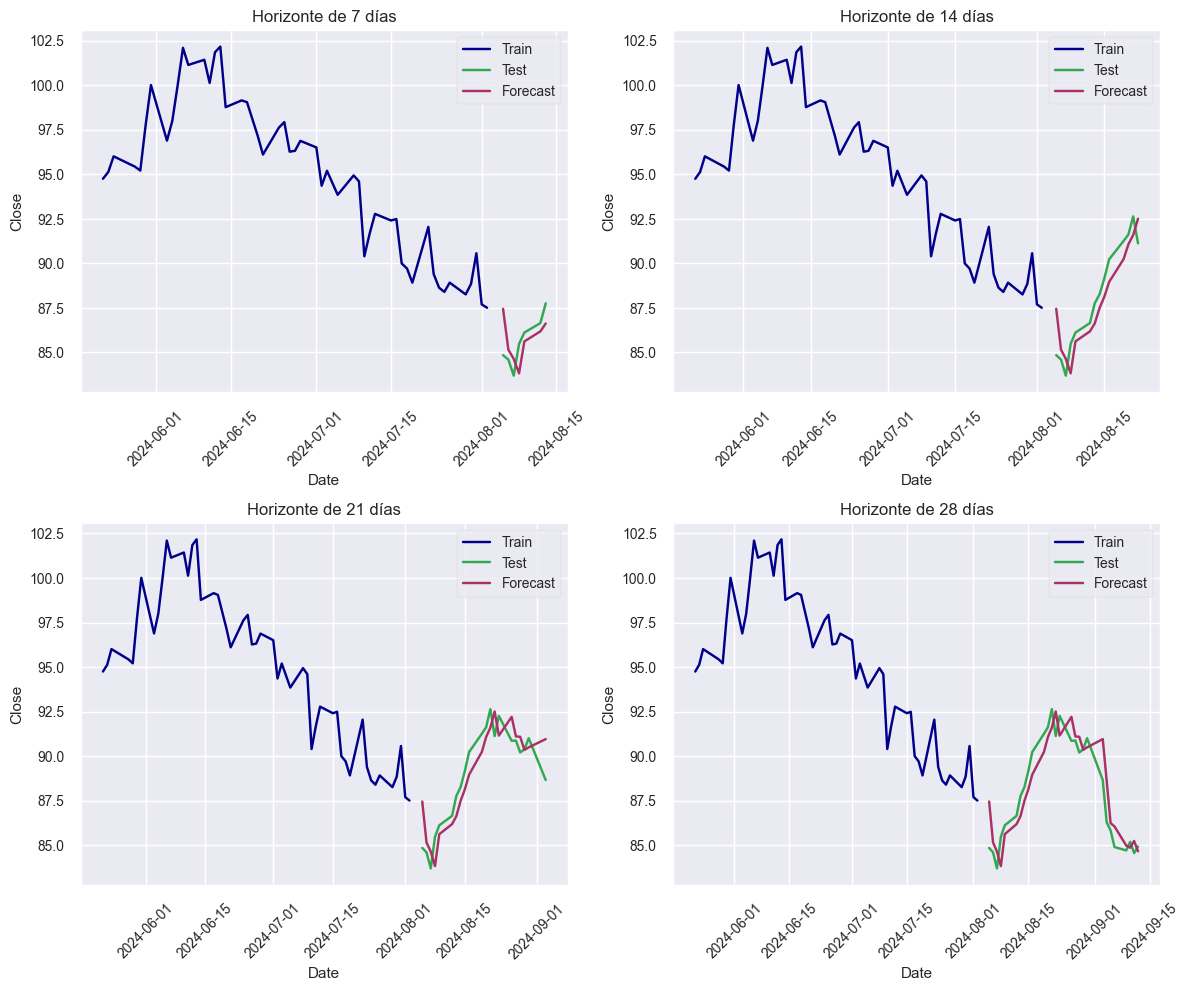

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

horizons = [7, 14, 21, 28]

for i, horizon in enumerate(horizons):
    ax = axs[i // 2, i % 2]

    dates_test = dates[:horizon]
    predicted_values = [pd.Series(pred).values for pred in results_rolling[horizon]]
    
    test_df = pd.DataFrame({'Test': test[:horizon].values}, index=test[:horizon].index)

    pred_df = pd.DataFrame({
        'Date': dates_test,
        'Forecast': list(predicted_values)
    }).set_index('Date')

    
    train_dates = train.index
    train_values = train
    
    sns.lineplot(ax=ax, x=train_dates[-50:], y=train_values[-50:], label='Train', color='#00008B')
    sns.lineplot(ax=ax, x=pred_df.index, y=test_df['Test'], label='Test', color='#32a850')
    sns.lineplot(ax=ax, x=pred_df.index, y= [arr[0] for arr in pred_df['Forecast']], label='Forecast', color='#a83264')
    
    ax.set_title(f'Horizonte de {horizon} días')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

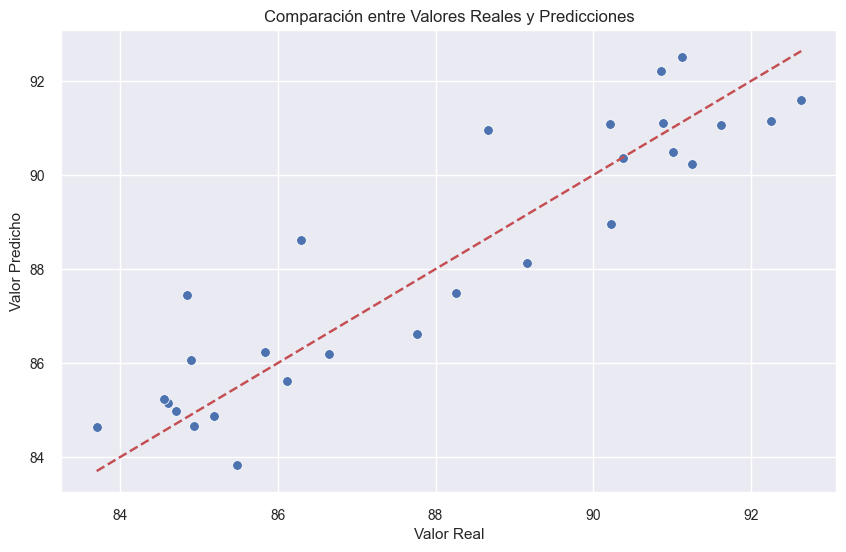

In [48]:
comparison_df = pd.DataFrame({
    'Real': test_df['Test'],
    'Predicted': [arr[0] for arr in pred_df['Forecast']]
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=comparison_df, x='Real', y='Predicted', ax=ax, color='b', marker='o')

min_val = min(comparison_df['Real'].min(), comparison_df['Predicted'].min())
max_val = max(comparison_df['Real'].max(), comparison_df['Predicted'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--')

ax.set_title('Comparación entre Valores Reales y Predicciones')
ax.set_xlabel('Valor Real')
ax.set_ylabel('Valor Predicho')
ax.grid(True)

plt.show()

Se observa como los datos predichos con el mejor orden según AIC con ARIMA con rolling vs. los esperados siguen una distribución bastante cercana a una recta de 45 grados.

In [49]:
d7 = create_error_table(test_df['Test'][:7], [arr[0] for arr in pred_df['Forecast']][:7])
d14  = create_error_table(test_df['Test'][:14], [arr[0] for arr in pred_df['Forecast']][:14])
d21= create_error_table(test_df['Test'][:21], [arr[0] for arr in pred_df['Forecast']][:21])
d28  = create_error_table(test_df['Test'][:28], [arr[0] for arr in pred_df['Forecast']][:28])

raic = pd.DataFrame({
    'Métrica': d7['Métrica'],
    'Días 7': d7['Valor'],
    'Días 14': d14['Valor'],
    'Días 21': d21['Valor'],
    'Días 28': d28['Valor']
})

raic

,Métrica,Días 7,Días 14,Días 21,Días 28
0,MAPE,1.312539,1.212652,1.146243,1.087074
1,MAE,1.121135,1.064800,1.014617,0.955439
2,MSE,1.777947,1.431246,1.402353,1.324720
3,RMSE,1.333397,1.196347,1.184210,1.150965
4,R2,-0.108722,0.822724,0.802789,0.835196


Los resultados de las métricas de evaluación del modelo para 28 días reflejan una buena precisión en las predicciones. El *MAPE* es de 1.087, lo que indica que, en promedio, las predicciones difieren del valor real en aproximadamente un 1.09%. El *MAE* es de 0.955, mostrando que el error absoluto medio es de 0.96 unidades, mientras que el *MSE* es de 1.324, lo que refleja la magnitud promedio de los errores cuadráticos, sugiriendo que algunos errores grandes están afectando más el resultado. El *RMSE*, que ajusta los errores al nivel original de los datos, es de 1.151, lo que indica un error promedio de 1.15 unidades. Finalmente, el *R2* de 0.835 sugiere que el modelo explica el 83.5% de la variabilidad de los datos, lo que implica un buen ajuste.

### $\mathtt{ARIMA\;sin\;rolling}$

In [50]:
def arima_no_rolling(train, test, best_order, horizons):
    results = {}
    predictions_dates = {}

    for horizon in horizons:
        model_fit = fit_arima_model(train, best_order)

        if model_fit:
            predictions = model_fit.forecast(steps=horizon)
            prediction_dates = test.index[:horizon]
            real_values = test[:horizon]
            predictions_dates[horizon] = prediction_dates
            results[horizon] = predictions
        else:
            print(f"Error al ajustar el modelo ARIMA para horizonte {horizon} días.")
            results[horizon] = np.nan

    for horizon in horizons:

        for i, date in enumerate(predictions_dates[horizon]):
            try:
                real_value = real_values.iloc[i]
                predicted_value = results[horizon][i + len(train)]
                print(f"{date.date()} | {real_value:.4f}      | {predicted_value:.4f}")
            except IndexError:
                print(f"Error de índice en horizonte {horizon}, posición {i}")
                break
    return results, predictions_dates

In [51]:
horizons = [7, 14, 21, 28]
results_no_rolling, prediction_dates_no_rolling = arima_no_rolling(train, test, results['best_order_aic'], horizons)

2024-08-05 | 84.8500      | 87.4542
2024-08-06 | 84.6000      | 87.7389
2024-08-07 | 83.7000      | 87.6074
2024-08-08 | 85.4800      | 87.5688
2024-08-09 | 86.1200      | 87.3852
2024-08-12 | 86.6500      | 87.5196
2024-08-13 | 87.7600      | 87.6201
2024-08-05 | 84.8500      | 87.4542
2024-08-06 | 84.6000      | 87.7389
2024-08-07 | 83.7000      | 87.6074
2024-08-08 | 85.4800      | 87.5688
2024-08-09 | 86.1200      | 87.3852
2024-08-12 | 86.6500      | 87.5196
2024-08-13 | 87.7600      | 87.6201
2024-08-14 | 88.2600      | 87.6948
2024-08-15 | 89.1600      | 87.5598
2024-08-16 | 90.2300      | 87.4377
2024-08-19 | 91.2600      | 87.4636
2024-08-20 | 91.6200      | 87.5922
2024-08-21 | 92.6400      | 87.6980
2024-08-22 | 91.1300      | 87.5921
2024-08-05 | 84.8500      | 87.4542
2024-08-06 | 84.6000      | 87.7389
2024-08-07 | 83.7000      | 87.6074
2024-08-08 | 85.4800      | 87.5688
2024-08-09 | 86.1200      | 87.3852
2024-08-12 | 86.6500      | 87.5196
2024-08-13 | 87.7600      | 

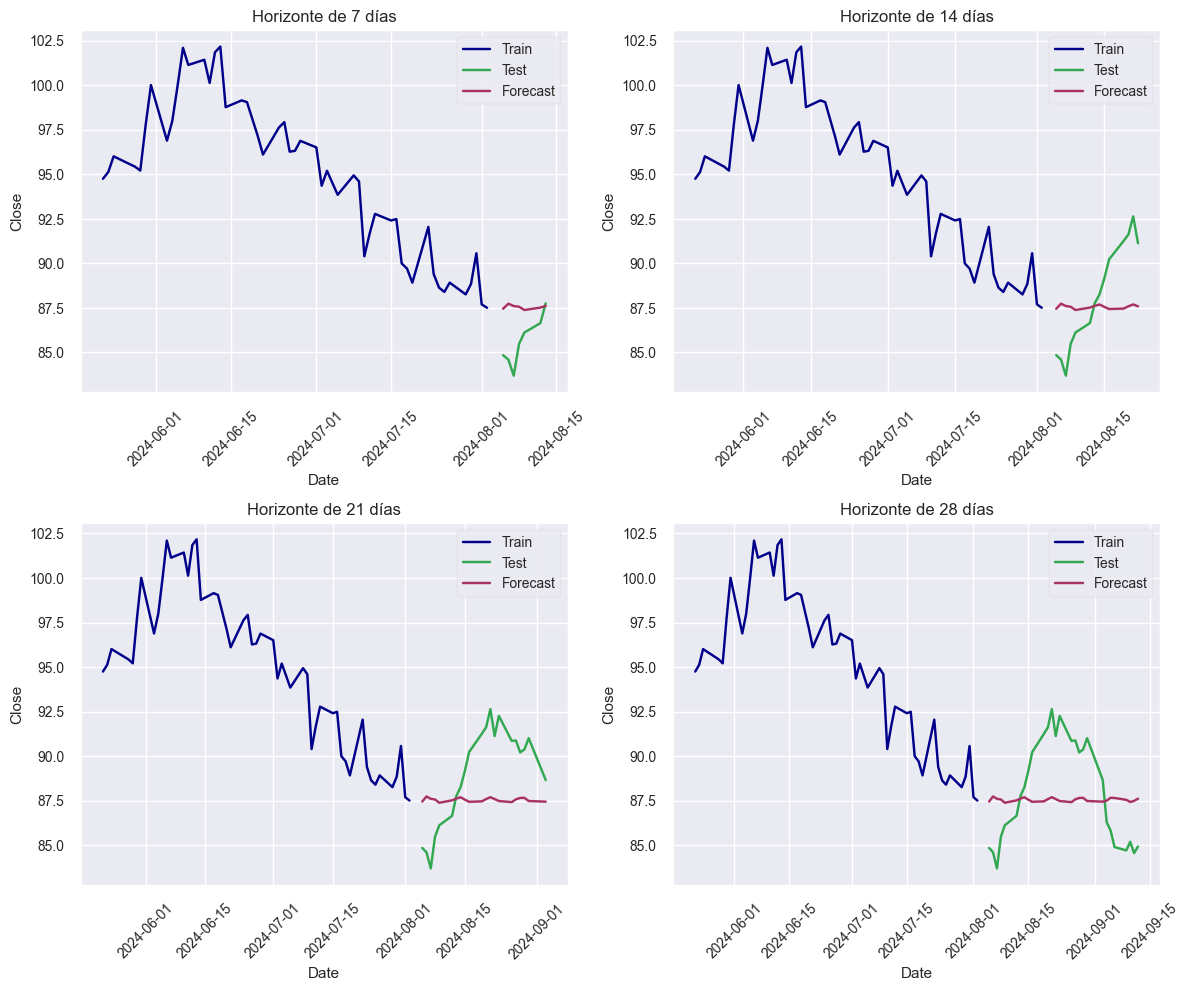

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

horizons = [7, 14, 21, 28]

for i, horizon in enumerate(horizons):
    ax = axs[i // 2, i % 2]
    
    dates_test = prediction_dates_no_rolling[horizon]
    test_values = test.loc[dates_test]
    predicted_values = results_no_rolling[horizon]

    train_dates = train.index
    train_values = train
    
    sns.lineplot(ax=ax, x=train_dates[-50:], y=train_values[-50:], label='Train', color='#00008B')
    sns.lineplot(ax=ax, x=dates_test, y=test_values, label='Test', color='#32a850')
    sns.lineplot(ax=ax, x=dates_test, y=predicted_values, label='Forecast', color='#a83264')
    
    ax.set_title(f'Horizonte de {horizon} días')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()


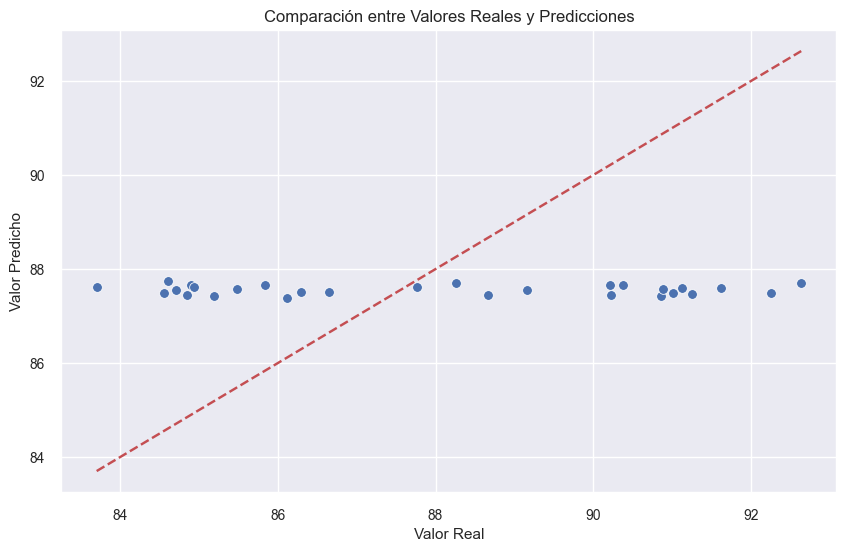

In [53]:
comparison_df = pd.DataFrame({
    'Real': test_values.tolist(),
    'Predicted': results_no_rolling[28].tolist()
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=comparison_df, x='Real', y='Predicted', ax=ax, color='b', marker='o')

min_val = min(comparison_df['Real'].min(), comparison_df['Predicted'].min())
max_val = max(comparison_df['Real'].max(), comparison_df['Predicted'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--')

ax.set_title('Comparación entre Valores Reales y Predicciones')
ax.set_xlabel('Valor Real')
ax.set_ylabel('Valor Predicho')
ax.grid(True)

plt.show()

La gráfica de correlación para los valores predichos con los esperados del conjunto de test para ARIMA (AIC) sin rolling no se ve para nada bien, los valores obtenidos de las predicciones son todos muy similares, tal como se observa en las cuatro gráficas de arriba, cuyas predicciones siguen una distribución practicamente lineal (180 grados). 

In [54]:
d7 = create_error_table(test_values[:7], predicted_values[:7])
d14  = create_error_table(test_values[:14], predicted_values[:14])
d21= create_error_table(test_values[:21], predicted_values[:21])
d28  = create_error_table(test_values[:28], predicted_values[:28])

nraic = pd.DataFrame({
    'Métrica': d7['Métrica'],
    'Días 7': d7['Valor'],
    'Días 14': d14['Valor'],
    'Días 21': d21['Valor'],
    'Días 28': d28['Valor']
})

nraic

,Métrica,Días 7,Días 14,Días 21,Días 28
0,MAPE,NaN,NaN,NaN,NaN
1,MAE,2.002013,2.519703,2.705316,2.618068
2,MSE,5.520341,8.349668,9.062227,8.271219
3,RMSE,2.349541,2.889579,3.010353,2.875973
4,R2,-2.442467,-0.034200,-0.274406,-0.028992


El *MAE* es de 2.618, lo que significa que, en promedio, las predicciones a 28 días difieren de los valores reales en 2.62 unidades. El *MSE*, que mide los errores cuadráticos, es de 8.271, lo que sugiere la presencia de errores relativamente grandes. El RMSE, que es la raíz cuadrada del *MSE*, es de 2.876, indicando que el error promedio en las predicciones es alto. Finalmente, el R2 es negativo (-0.029), lo que implica que el modelo no explica la variabilidad de los datos, siendo incluso peor que simplemente predecir el valor promedio. Esto indica un ajuste deficiente del modelo.

### $\mathtt{Normalidad\;e\;independencia\;de\;los\;residuos}$

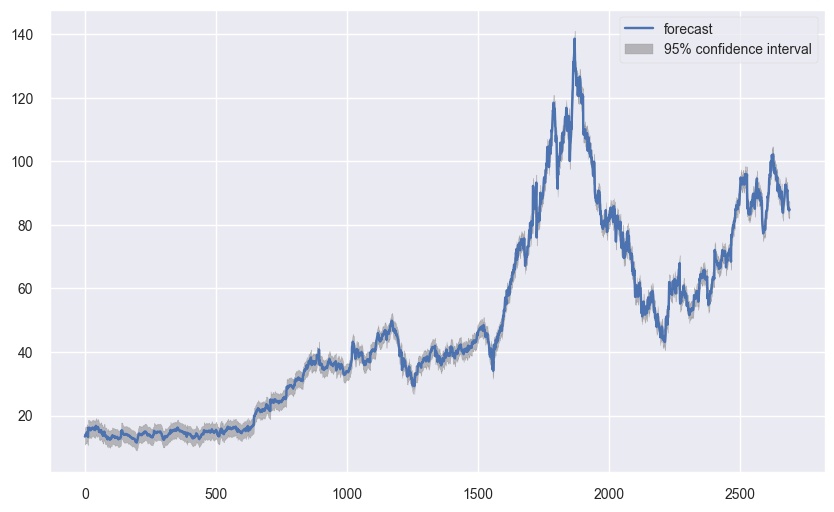

In [97]:
modeloaic = ARIMA(data['Close'].tolist(),order = results['best_order_hqic']).fit()

plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots()
plot_predict(modeloaic, 2, ax = ax)
plt.show()

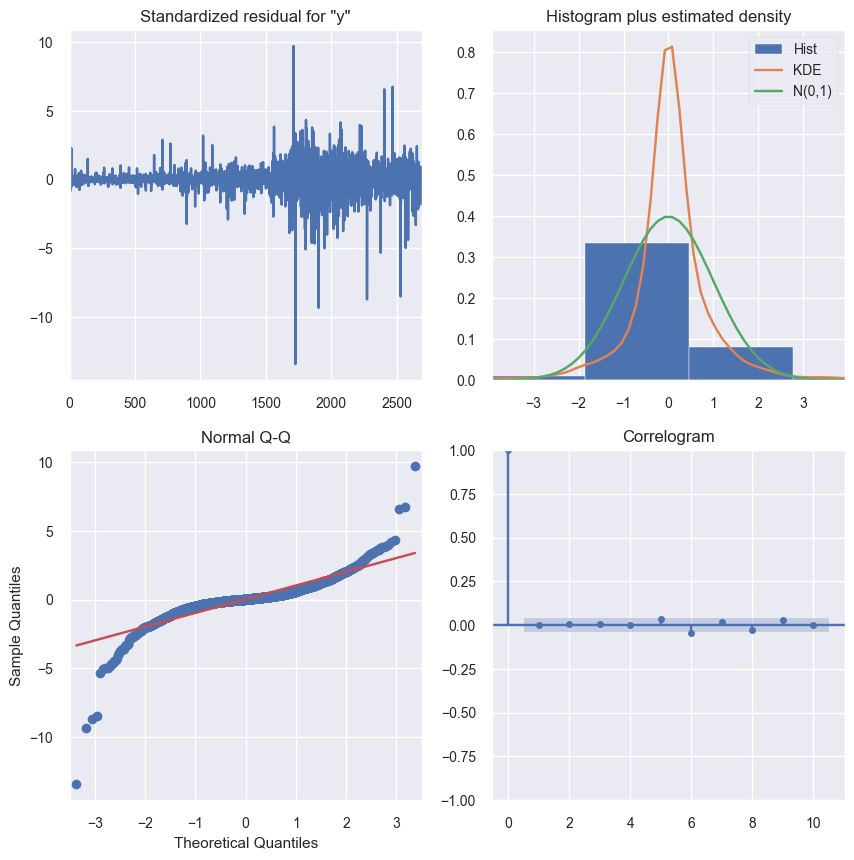

In [99]:
modeloaic.plot_diagnostics()
plt.show()

El primer gráfico muestra los residuos (diferencia entre los valores observados y los valores ajustados) frente a los valores ajustados. Idealmente, los residuos deben estar distribuidos aleatoriamente alrededor de cero y no mostrar ningún patrón sistemático, sin embargo, en la gráfica en bastantes observaciones estos residuos difieren bastante de 0.

El segundo gráfico, histograma, muestra la distribución de los residuos en un histograma. La distribución debería parecerse a una distribución normal, con una forma de campana simétrica alrededor de cero. Un histograma muy asimétrico o sesgado indica que los residuos no están distribuidos normalmente. Tal como se observa en la gráfica, estos residuos no siguen una distribución normal, lo cual es confirmado con el tercer gráfico: Q-Q plot.

En cuanto a la cuarta gráfica, el correlograma, no se observa autocorrelación significativa en los diferentes retardos (lags). En el gráfico, las barras que se extienden más allá de las bandas de confianza indican autocorrelación en esos retardos, lo que sugiere que el modelo puede no estar capturando todas las dependencias en los datos, sin embargo, esto no se presenta para este modelo. 

In [93]:
resid_clean = pd.Series(modeloaic.resid).replace([np.inf, -np.inf], np.nan).dropna()
stat, p = shapiro(resid_clean)

alpha = 0.05
if p > alpha:
    print('Normal')
else:
    print('No normal')

print('Statistics=%.3f, p=%.3f' % (stat, p))

No normal
Statistics=0.777, p=0.000


Esto confirma que los residuos no siguen una distribución normal, tal como se observaba en el histograma y los Q-Q plots.

## $\mathtt{ARIMA:\;BIC}$
### $\mathtt{ARIMA \; con\;rolling}$

In [55]:
horizons = [7, 14, 21, 28]
results_rolling = {}

for i in horizons:
    results_rolling[i] = arima_rolling(list(train), test[:i], results['best_order_bic'])

predicted=87.510002, expected=84.849998
predicted=84.849998, expected=84.599998
predicted=84.599998, expected=83.699997
predicted=83.699997, expected=85.480003
predicted=85.480003, expected=86.120003
predicted=86.120003, expected=86.650002
predicted=86.650002, expected=87.760002
predicted=87.510002, expected=84.849998
predicted=84.849998, expected=84.599998
predicted=84.599998, expected=83.699997
predicted=83.699997, expected=85.480003
predicted=85.480003, expected=86.120003
predicted=86.120003, expected=86.650002
predicted=86.650002, expected=87.760002
predicted=87.760002, expected=88.260002
predicted=88.260002, expected=89.160004
predicted=89.160004, expected=90.230003
predicted=90.230003, expected=91.260002
predicted=91.260002, expected=91.620003
predicted=91.620003, expected=92.639999
predicted=92.639999, expected=91.129997
predicted=87.510002, expected=84.849998
predicted=84.849998, expected=84.599998
predicted=84.599998, expected=83.699997
predicted=83.699997, expected=85.480003


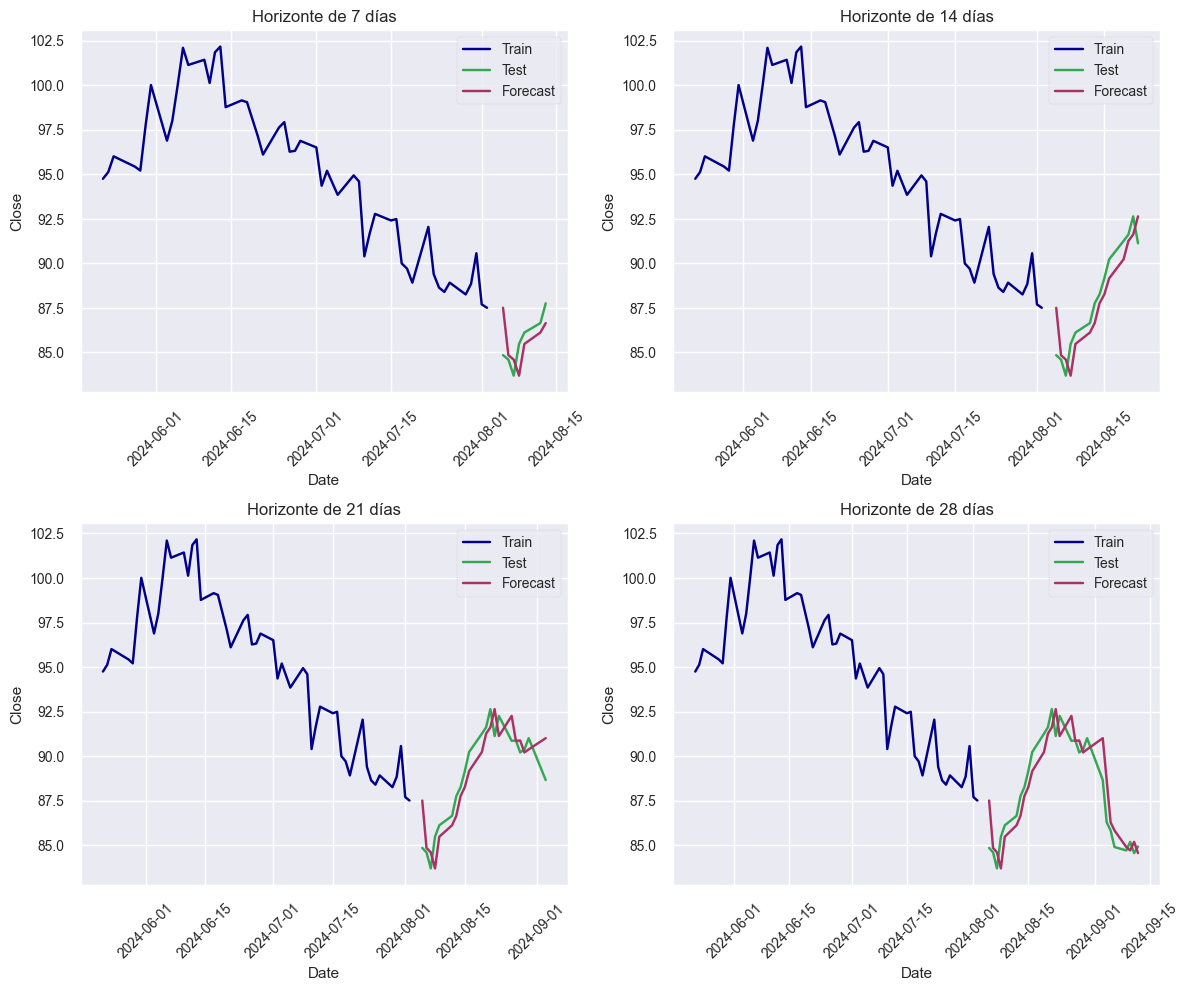

In [56]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

horizons = [7, 14, 21, 28]

for i, horizon in enumerate(horizons):
    ax = axs[i // 2, i % 2]

    dates_test = dates[:horizon]
    predicted_values = [pd.Series(pred).values for pred in results_rolling[horizon]]
    
    test_df = pd.DataFrame({'Test': test[:horizon].values}, index=test[:horizon].index)

    pred_df = pd.DataFrame({
        'Date': dates_test,
        'Forecast': list(predicted_values)
    }).set_index('Date')

    
    train_dates = train.index
    train_values = train
    
    sns.lineplot(ax=ax, x=train_dates[-50:], y=train_values[-50:], label='Train', color='#00008B')
    sns.lineplot(ax=ax, x=pred_df.index, y=test_df['Test'], label='Test', color='#32a850')
    sns.lineplot(ax=ax, x=pred_df.index, y= [arr[0] for arr in pred_df['Forecast']], label='Forecast', color='#a83264')
    
    ax.set_title(f'Horizonte de {horizon} días')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

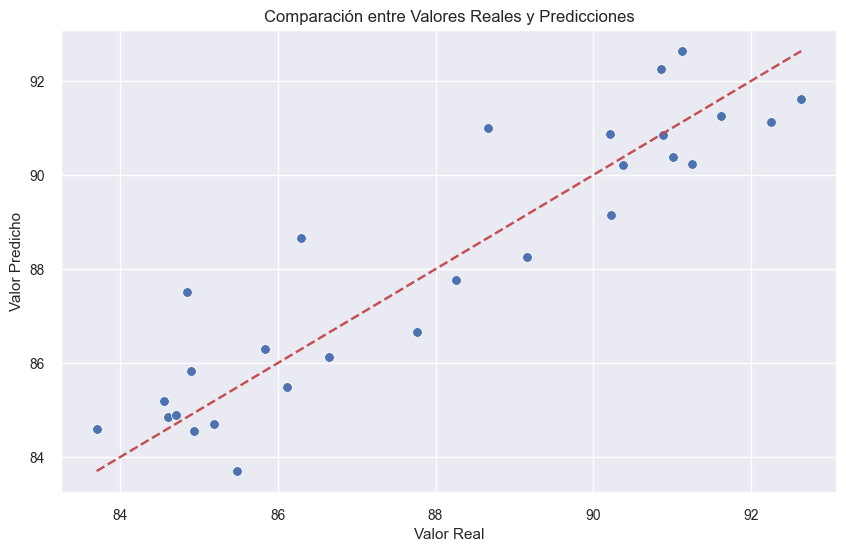

In [57]:
comparison_df = pd.DataFrame({
    'Real': test_df['Test'],
    'Predicted': [arr[0] for arr in pred_df['Forecast']]
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=comparison_df, x='Real', y='Predicted', ax=ax, color='b', marker='o')

min_val = min(comparison_df['Real'].min(), comparison_df['Predicted'].min())
max_val = max(comparison_df['Real'].max(), comparison_df['Predicted'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--')

ax.set_title('Comparación entre Valores Reales y Predicciones')
ax.set_xlabel('Valor Real')
ax.set_ylabel('Valor Predicho')
ax.grid(True)

plt.show()

Se observa como los datos predichos con el mejor orden según BIC con ARIMA con rolling vs. los esperados siguen una distribución bastante cercana a una recta de 45 grados.

In [58]:
d7 = create_error_table(test_df['Test'][:7], [arr[0] for arr in pred_df['Forecast']][:7])
d14  = create_error_table(test_df['Test'][:14], [arr[0] for arr in pred_df['Forecast']][:14])
d21= create_error_table(test_df['Test'][:21], [arr[0] for arr in pred_df['Forecast']][:21])
d28  = create_error_table(test_df['Test'][:28], [arr[0] for arr in pred_df['Forecast']][:28])

rbic = pd.DataFrame({
    'Métrica': d7['Métrica'],
    'Días 7': d7['Valor'],
    'Días 14': d14['Valor'],
    'Días 21': d21['Valor'],
    'Días 28': d28['Valor']
})

rbic

,Métrica,Días 7,Días 14,Días 21,Días 28
0,MAPE,1.315387,1.160648,1.110016,1.059167
1,MAE,1.124287,1.018572,0.982382,0.930715
2,MSE,1.862735,1.411075,1.399503,1.317260
3,RMSE,1.364820,1.187887,1.183006,1.147719
4,R2,-0.161595,0.825223,0.803190,0.836125



Los resultados indican que para la predicción a 28 días el modelo tiene un rendimiento decente en las predicciones. El *MAPE* es de 1.06%, lo que significa que el error absoluto porcentual promedio es bajo, indicando buenas predicciones en términos relativos. El *MAE* es de 0.93, lo que sugiere que, en promedio, las predicciones difieren de los valores reales en menos de una unidad. El *MSE*, que mide los errores cuadráticos, es de 1.32, mientras que el *RMSE* es de 1.15, lo que indica que los errores promedio son bajos en términos absolutos. Finalmente, el *R2* de 0.836 indica que el modelo explica el 83.6% de la variabilidad de los datos, lo que sugiere un buen ajuste del modelo.

### $\mathtt{ARIMA \; sin\;rolling}$

In [59]:
horizons = [7, 14, 21, 28]
results_no_rolling, prediction_dates_no_rolling = arima_no_rolling(train, test, results['best_order_bic'], horizons)

2024-08-05 | 84.8500      | 87.5100
2024-08-06 | 84.6000      | 87.5100
2024-08-07 | 83.7000      | 87.5100
2024-08-08 | 85.4800      | 87.5100
2024-08-09 | 86.1200      | 87.5100
2024-08-12 | 86.6500      | 87.5100
2024-08-13 | 87.7600      | 87.5100
2024-08-05 | 84.8500      | 87.5100
2024-08-06 | 84.6000      | 87.5100
2024-08-07 | 83.7000      | 87.5100
2024-08-08 | 85.4800      | 87.5100
2024-08-09 | 86.1200      | 87.5100
2024-08-12 | 86.6500      | 87.5100
2024-08-13 | 87.7600      | 87.5100
2024-08-14 | 88.2600      | 87.5100
2024-08-15 | 89.1600      | 87.5100
2024-08-16 | 90.2300      | 87.5100
2024-08-19 | 91.2600      | 87.5100
2024-08-20 | 91.6200      | 87.5100
2024-08-21 | 92.6400      | 87.5100
2024-08-22 | 91.1300      | 87.5100
2024-08-05 | 84.8500      | 87.5100
2024-08-06 | 84.6000      | 87.5100
2024-08-07 | 83.7000      | 87.5100
2024-08-08 | 85.4800      | 87.5100
2024-08-09 | 86.1200      | 87.5100
2024-08-12 | 86.6500      | 87.5100
2024-08-13 | 87.7600      | 

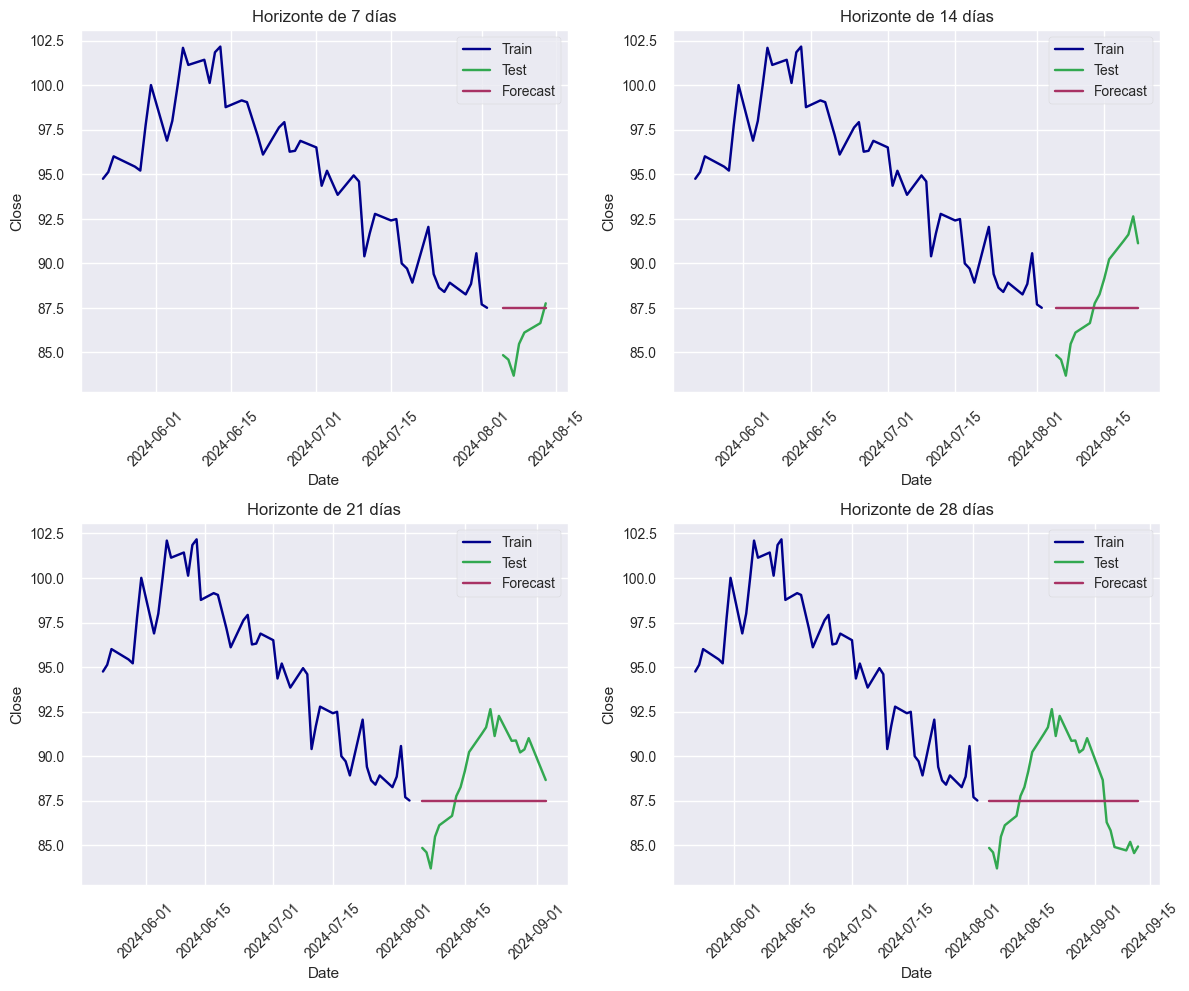

In [60]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

horizons = [7, 14, 21, 28]

for i, horizon in enumerate(horizons):
    ax = axs[i // 2, i % 2]
    
    dates_test = prediction_dates_no_rolling[horizon]
    test_values = test.loc[dates_test]
    predicted_values = results_no_rolling[horizon]

    train_dates = train.index
    train_values = train
    
    sns.lineplot(ax=ax, x=train_dates[-50:], y=train_values[-50:], label='Train', color='#00008B')
    sns.lineplot(ax=ax, x=dates_test, y=test_values, label='Test', color='#32a850')
    sns.lineplot(ax=ax, x=dates_test, y=predicted_values, label='Forecast', color='#a83264')
    
    ax.set_title(f'Horizonte de {horizon} días')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()


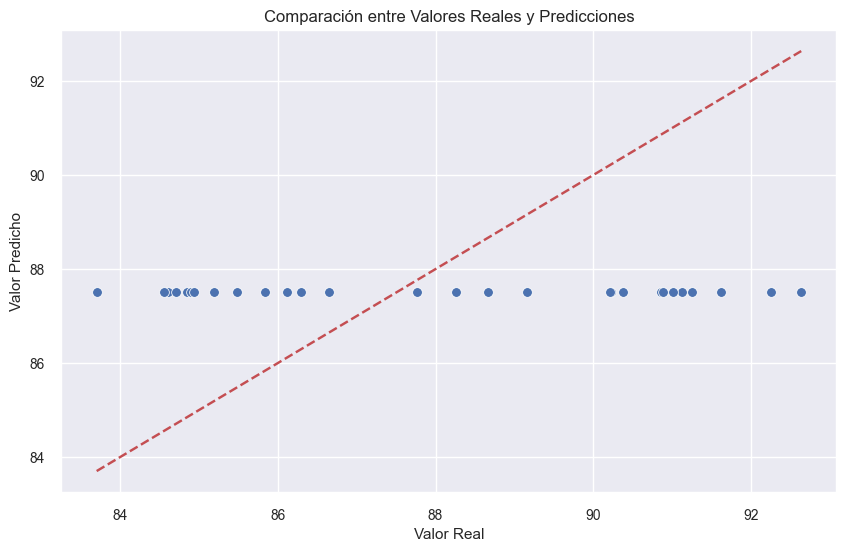

In [61]:
comparison_df = pd.DataFrame({
    'Real': test_values.tolist(),
    'Predicted': results_no_rolling[28].tolist()
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=comparison_df, x='Real', y='Predicted', ax=ax, color='b', marker='o')

min_val = min(comparison_df['Real'].min(), comparison_df['Predicted'].min())
max_val = max(comparison_df['Real'].max(), comparison_df['Predicted'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--')

ax.set_title('Comparación entre Valores Reales y Predicciones')
ax.set_xlabel('Valor Real')
ax.set_ylabel('Valor Predicho')
ax.grid(True)

plt.show()

La gráfica de correlación para los valores predichos con los esperados del conjunto de test para ARIMA (AIC) sin rolling no se ve para nada bien, los valores obtenidos de las predicciones son todos muy similares, tal como se observa en las cuatro gráficas de arriba, cuyas predicciones siguen una distribución practicamente lineal (180 grados). 

In [62]:
d7 = create_error_table(test_values[:7], predicted_values[:7])
d14  = create_error_table(test_values[:14], predicted_values[:14])
d21= create_error_table(test_values[:21], predicted_values[:21])
d28  = create_error_table(test_values[:28], predicted_values[:28])

nrbic = pd.DataFrame({
    'Métrica': d7['Métrica'],
    'Días 7': d7['Valor'],
    'Días 14': d14['Valor'],
    'Días 21': d21['Valor'],
    'Días 28': d28['Valor']
})

nrbic

,Métrica,Días 7,Días 14,Días 21,Días 28
0,MAPE,NaN,NaN,NaN,NaN
1,MAE,1.987144,2.545715,2.730000,2.624643
2,MSE,5.273568,8.426731,9.153116,8.282847
3,RMSE,2.296425,2.902883,3.025412,2.877993
4,R2,-2.288580,-0.043745,-0.287187,-0.030439


Los resultados sugieren que el modelo para 28 días tiene un rendimiento deficiente. El *MAE* es de 2.62, lo que significa que el error absoluto promedio es relativamente alto. El *MSE* de 8.28 y el RMSE de 2.88 reflejan errores grandes en las predicciones en comparación con los valores reales. El *R2* es negativo (-0.03), lo que indica que el modelo no es capaz de explicar la variabilidad de los datos y, en realidad, es peor que una predicción basada en la media.

### $\mathtt{Normalidad\;e\;independencia\;de\;los\;residuos}$

In [87]:
modelobic = ARIMA(data['Close'].tolist(),order = results['best_order_bic']).fit()

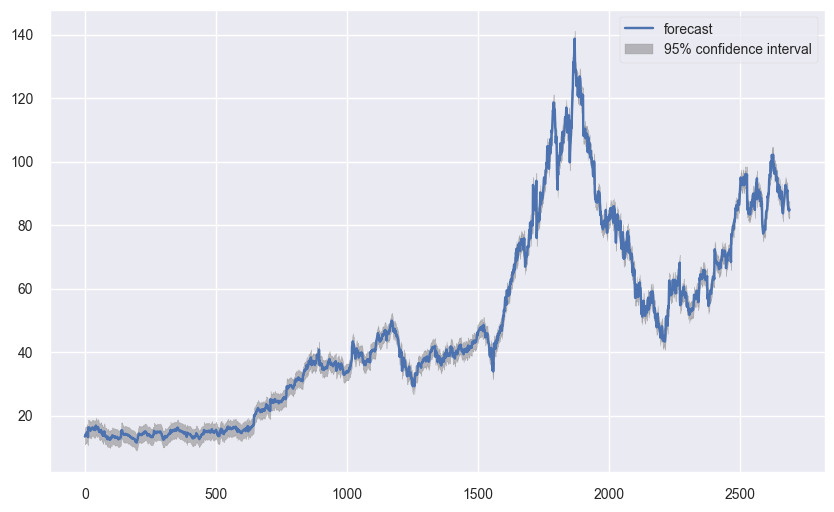

In [88]:
plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots()
plot_predict(modelobic, 2, ax = ax)
plt.show()

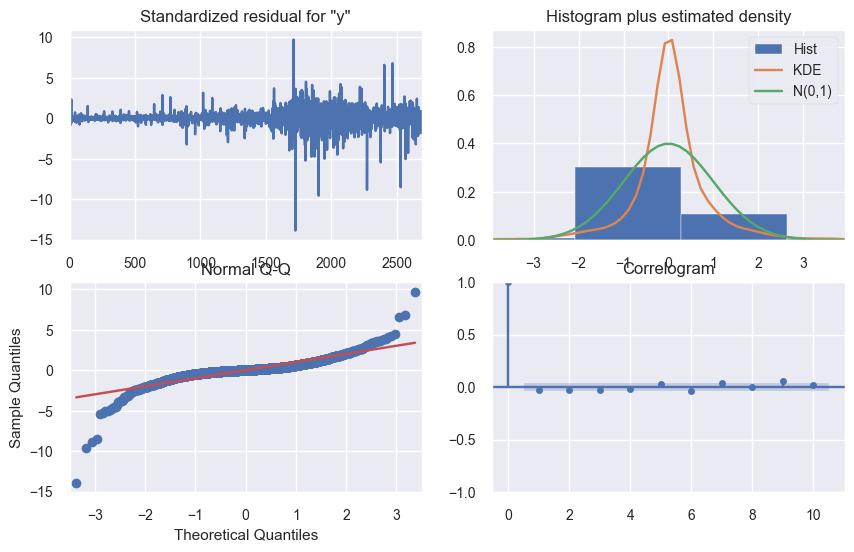

In [89]:
modelobic.plot_diagnostics()
plt.show()

El primer gráfico muestra los residuos (diferencia entre los valores observados y los valores ajustados) frente a los valores ajustados. Idealmente, los residuos deben estar distribuidos aleatoriamente alrededor de cero y no mostrar ningún patrón sistemático, sin embargo, en la gráfica en bastantes observaciones estos residuos difieren bastante de 0.

El segundo gráfico, histograma, muestra la distribución de los residuos en un histograma. La distribución debería parecerse a una distribución normal, con una forma de campana simétrica alrededor de cero. Un histograma muy asimétrico o sesgado indica que los residuos no están distribuidos normalmente. Tal como se observa en la gráfica, estos residuos no siguen una distribución normal, lo cual es confirmado con el tercer gráfico: Q-Q plot.

En cuanto a la cuarta gráfica, el correlograma, no se observa autocorrelación significativa en los diferentes retardos (lags). En el gráfico, las barras que se extienden más allá de las bandas de confianza indican autocorrelación en esos retardos, lo que sugiere que el modelo puede no estar capturando todas las dependencias en los datos, sin embargo, esto no se presenta para este modelo. 

In [90]:
resid_clean = pd.Series(modelobic.resid).replace([np.inf, -np.inf], np.nan).dropna()
stat, p = shapiro(resid_clean)

alpha = 0.05
if p > alpha:
    print('Normal')
else:
    print('No normal')

print('Statistics=%.3f, p=%.3f' % (stat, p))

No normal
Statistics=0.770, p=0.000


Esto confirma que los residuos no siguen una distribución normal, tal como se observaba en el histograma y los Q-Q plots.

## $\mathtt{ARIMA:\;HQIC}$
### $\mathtt{ARIMA \; con\;rolling}$

In [63]:
horizons = [7, 14, 21, 28]
results_rolling = {}

for i in horizons:
    results_rolling[i] = arima_rolling(list(train), test[:i], results['best_order_hqic'])

predicted=87.540915, expected=84.849998
predicted=0.000000, expected=84.599998
predicted=84.738930, expected=83.699997
predicted=83.834252, expected=85.480003
predicted=85.511683, expected=86.120003
predicted=86.043793, expected=86.650002
predicted=86.498993, expected=87.760002
predicted=87.540915, expected=84.849998
predicted=0.000000, expected=84.599998
predicted=84.738930, expected=83.699997
predicted=83.834252, expected=85.480003
predicted=85.511683, expected=86.120003
predicted=86.043793, expected=86.650002
predicted=86.498993, expected=87.760002
predicted=87.679529, expected=88.260002
predicted=88.031198, expected=89.160004
predicted=88.948909, expected=90.230003
predicted=90.056308, expected=91.260002
predicted=91.141990, expected=91.620003
predicted=91.585299, expected=92.639999
predicted=92.669868, expected=91.129997
predicted=87.540915, expected=84.849998
predicted=0.000000, expected=84.599998
predicted=84.738930, expected=83.699997
predicted=83.834252, expected=85.480003
pre

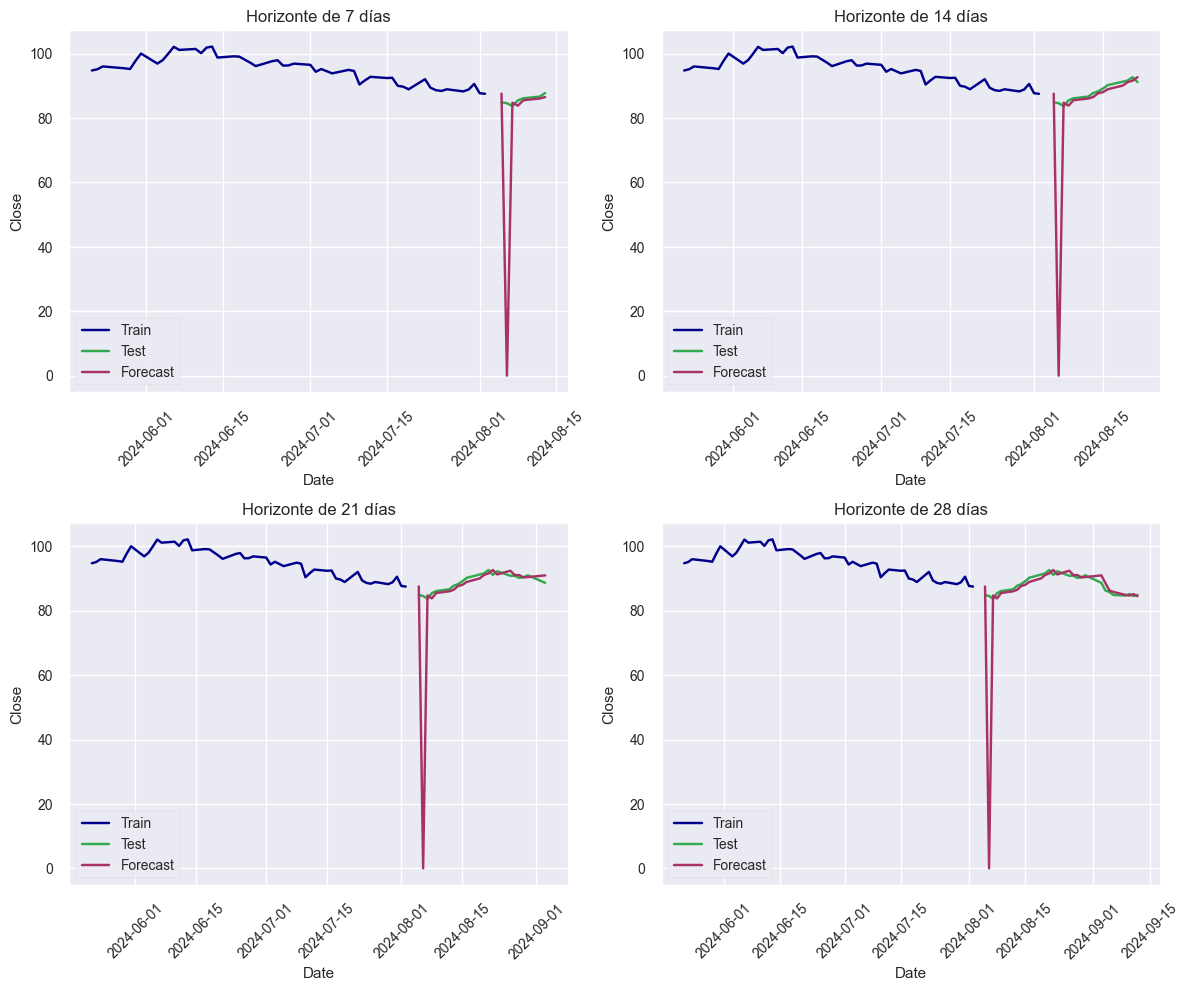

In [64]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

horizons = [7, 14, 21, 28]

for i, horizon in enumerate(horizons):
    ax = axs[i // 2, i % 2]

    dates_test = dates[:horizon]
    predicted_values = [pd.Series(pred).values for pred in results_rolling[horizon]]
    
    test_df = pd.DataFrame({'Test': test[:horizon].values}, index=test[:horizon].index)

    pred_df = pd.DataFrame({
        'Date': dates_test,
        'Forecast': list(predicted_values)
    }).set_index('Date')

    
    train_dates = train.index
    train_values = train
    
    sns.lineplot(ax=ax, x=train_dates[-50:], y=train_values[-50:], label='Train', color='#00008B')
    sns.lineplot(ax=ax, x=pred_df.index, y=test_df['Test'], label='Test', color='#32a850')
    sns.lineplot(ax=ax, x=pred_df.index, y= [arr[0] for arr in pred_df['Forecast']], label='Forecast', color='#a83264')
    
    ax.set_title(f'Horizonte de {horizon} días')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

plt.tight_layout()
plt.show()

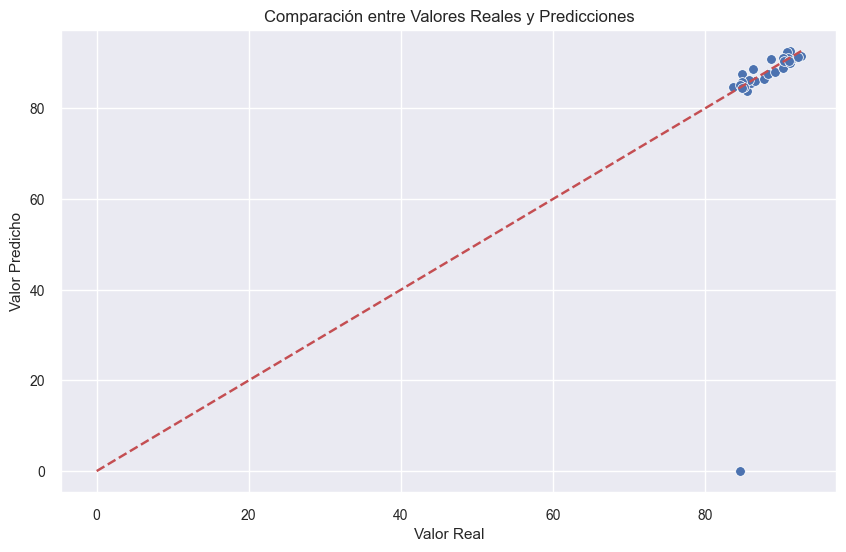

In [65]:
comparison_df = pd.DataFrame({
    'Real': test_df['Test'],
    'Predicted': [arr[0] for arr in pred_df['Forecast']]
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=comparison_df, x='Real', y='Predicted', ax=ax, color='b', marker='o')

min_val = min(comparison_df['Real'].min(), comparison_df['Predicted'].min())
max_val = max(comparison_df['Real'].max(), comparison_df['Predicted'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--')

ax.set_title('Comparación entre Valores Reales y Predicciones')
ax.set_xlabel('Valor Real')
ax.set_ylabel('Valor Predicho')
ax.grid(True)

plt.show()

Hubo un día muy mal ajustada por el modelo que daña todas las métricas tenidas en cuenta. Predice un valor de 0. 

In [66]:
d7 = create_error_table(test_df['Test'][:7], [arr[0] for arr in pred_df['Forecast']][:7])
d14  = create_error_table(test_df['Test'][:14], [arr[0] for arr in pred_df['Forecast']][:14])
d21= create_error_table(test_df['Test'][:21], [arr[0] for arr in pred_df['Forecast']][:21])
d28  = create_error_table(test_df['Test'][:28], [arr[0] for arr in pred_df['Forecast']][:28])

rhqic = pd.DataFrame({
    'Métrica': d7['Métrica'],
    'Días 7': d7['Valor'],
    'Días 14': d14['Valor'],
    'Días 21': d21['Valor'],
    'Días 28': d28['Valor']
})

rhqic

,Métrica,Días 7,Días 14,Días 21,Días 28
0,MAPE,15.597257,8.370949,5.924117,4.669373
1,MAE,13.207305,7.122699,5.058275,3.987300
2,MSE,1024.359477,512.780690,342.326566,257.006110
3,RMSE,32.005616,22.644661,18.502069,16.031410
4,R2,-637.787237,-62.513607,-47.140810,-30.973186


Los resultados muestran que el modelo tiene un rendimiento extremadamente pobre para la predicción tanto de 7, 14, 21 y 28 días. En el caso de 28 días, el *MAPE* de 4.67 indica que el error porcentual promedio es muy elevado, lo que significa que las predicciones están lejos de los valores reales. El *MAE* de 3.99 también refleja un error absoluto considerable en las predicciones. El *MSE*, con un valor de 257, y el *RMSE* de 16.03 sugieren grandes discrepancias entre las predicciones y los datos reales. Además, el *R2* negativo (-30.97) indica que el modelo no solo no explica la variabilidad de los datos, sino que está mucho peor que si se utilizara simplemente la media de los valores reales para hacer predicciones.

### $\mathtt{ARIMA \; sin\;rolling}$

In [67]:
horizons = [7, 14, 21, 28]
results_no_rolling, prediction_dates_no_rolling = arima_no_rolling(train, test, results['best_order_hqic'], horizons)

2024-08-05 | 84.8500      | 87.5409
2024-08-06 | 84.6000      | 87.5615
2024-08-07 | 83.7000      | 87.5665
2024-08-08 | 85.4800      | 87.5570
2024-08-09 | 86.1200      | 87.5367
2024-08-12 | 86.6500      | 87.5112
2024-08-13 | 87.7600      | 87.4862
2024-08-05 | 84.8500      | 87.5409
2024-08-06 | 84.6000      | 87.5615
2024-08-07 | 83.7000      | 87.5665
2024-08-08 | 85.4800      | 87.5570
2024-08-09 | 86.1200      | 87.5367
2024-08-12 | 86.6500      | 87.5112
2024-08-13 | 87.7600      | 87.4862
2024-08-14 | 88.2600      | 87.4669
2024-08-15 | 89.1600      | 87.4563
2024-08-16 | 90.2300      | 87.4554
2024-08-19 | 91.2600      | 87.4632
2024-08-20 | 91.6200      | 87.4769
2024-08-21 | 92.6400      | 87.4931
2024-08-22 | 91.1300      | 87.5080
2024-08-05 | 84.8500      | 87.5409
2024-08-06 | 84.6000      | 87.5615
2024-08-07 | 83.7000      | 87.5665
2024-08-08 | 85.4800      | 87.5570
2024-08-09 | 86.1200      | 87.5367
2024-08-12 | 86.6500      | 87.5112
2024-08-13 | 87.7600      | 

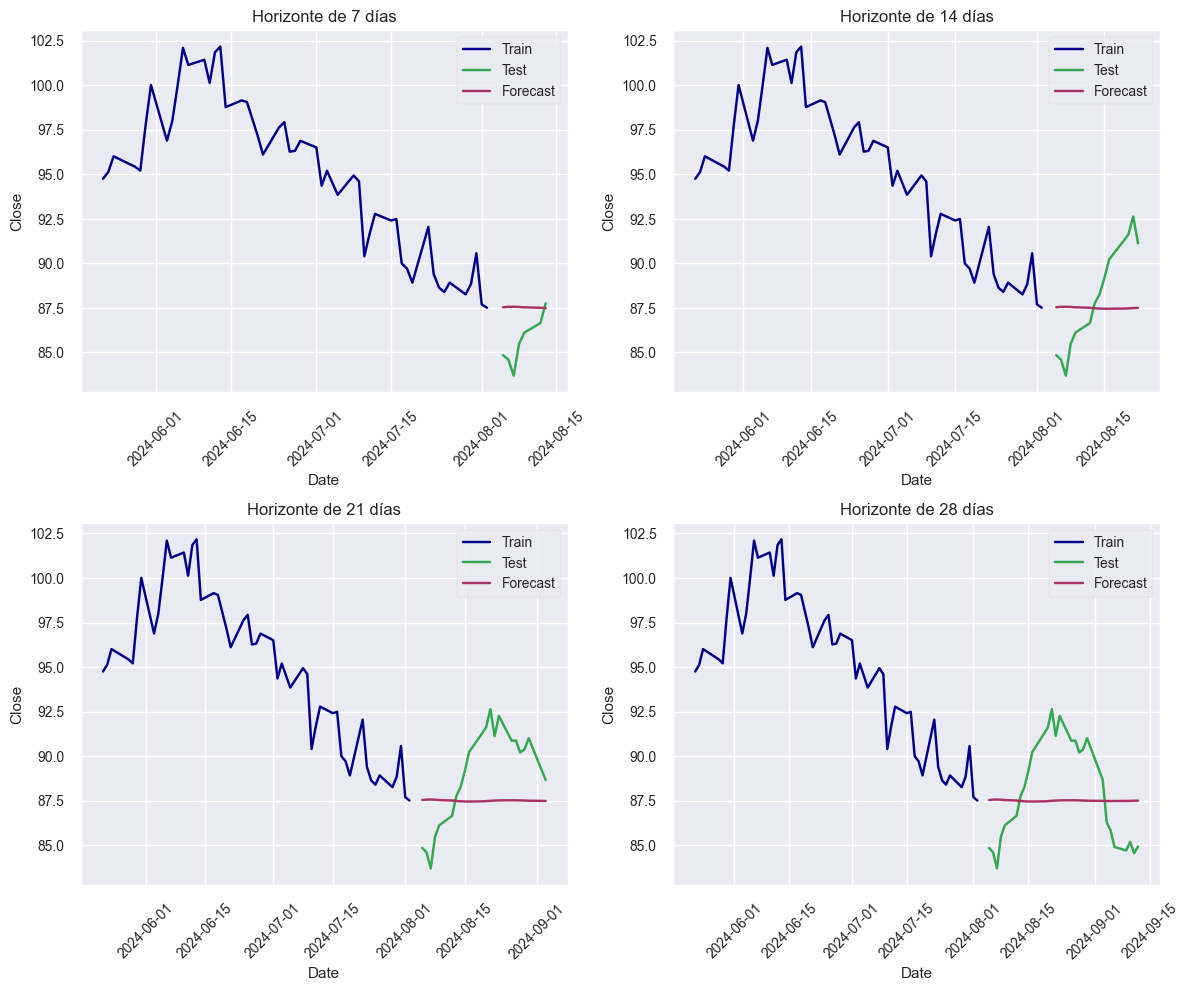

In [68]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

horizons = [7, 14, 21, 28]

for i, horizon in enumerate(horizons):
    ax = axs[i // 2, i % 2]
    
    dates_test = prediction_dates_no_rolling[horizon]
    test_values = test.loc[dates_test]
    predicted_values = results_no_rolling[horizon]

    train_dates = train.index
    train_values = train
    
    sns.lineplot(ax=ax, x=train_dates[-50:], y=train_values[-50:], label='Train', color='#00008B')
    sns.lineplot(ax=ax, x=dates_test, y=test_values, label='Test', color='#32a850')
    sns.lineplot(ax=ax, x=dates_test, y=predicted_values, label='Forecast', color='#a83264')
    
    ax.set_title(f'Horizonte de {horizon} días')
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

# Ajustar el diseño para evitar solapamientos
plt.tight_layout()
plt.show()


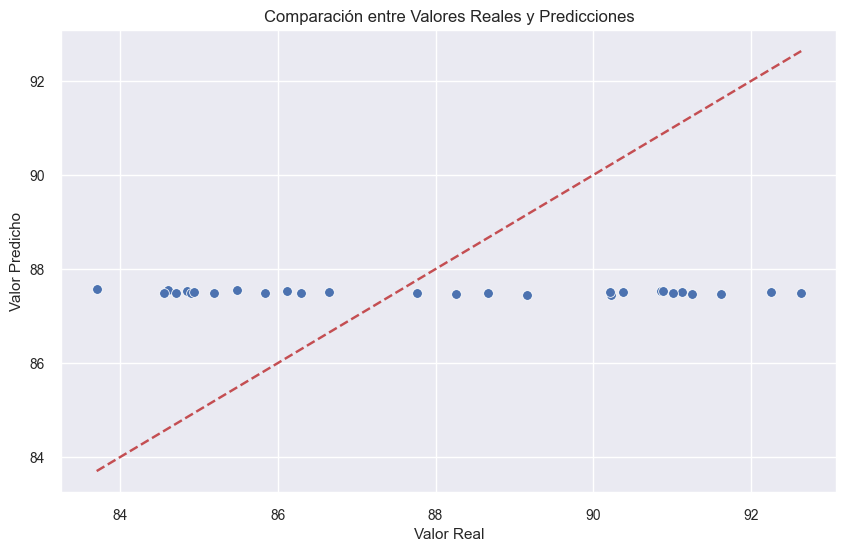

In [69]:
comparison_df = pd.DataFrame({
    'Real': test_values.tolist(),
    'Predicted': results_no_rolling[28].tolist()
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=comparison_df, x='Real', y='Predicted', ax=ax, color='b', marker='o')

min_val = min(comparison_df['Real'].min(), comparison_df['Predicted'].min())
max_val = max(comparison_df['Real'].max(), comparison_df['Predicted'].max())
ax.plot([min_val, max_val], [min_val, max_val], color='r', linestyle='--')

ax.set_title('Comparación entre Valores Reales y Predicciones')
ax.set_xlabel('Valor Real')
ax.set_ylabel('Valor Predicho')
ax.grid(True)

plt.show()

La gráfica de correlación para los valores predichos con los esperados del conjunto de test para ARIMA (QHIC) sin rolling no se ve para nada bien, los valores obtenidos de las predicciones son todos muy similares, tal como se observa en las cuatro gráficas de arriba, cuyas predicciones siguen una distribución practicamente lineal (180 grados). 

In [70]:
d7 = create_error_table(test_values[:7], predicted_values[:7])
d14  = create_error_table(test_values[:14], predicted_values[:14])
d21= create_error_table(test_values[:21], predicted_values[:21])
d28  = create_error_table(test_values[:28], predicted_values[:28])

nrhqic = pd.DataFrame({
    'Métrica': d7['Métrica'],
    'Días 7': d7['Valor'],
    'Días 14': d14['Valor'],
    'Días 21': d21['Valor'],
    'Días 28': d28['Valor']
})

nrhqic

,Métrica,Días 7,Días 14,Días 21,Días 28
0,MAPE,NaN,NaN,NaN,NaN
1,MAE,2.021080,2.580556,2.752778,2.636670
2,MSE,5.442725,8.608524,9.266348,8.345857
3,RMSE,2.332965,2.934029,3.044068,2.888920
4,R2,-2.394065,-0.066262,-0.303111,-0.038277


El *MAE* es de 2.636670, indicando que, en promedio, las predicciones para 28 días están a 2.637 unidades de los valores reales. El *MSE* es 8.345857, reflejando la variabilidad en los errores, mientras que el *RMSE*, con un valor de 2.888920, muestra que las predicciones se desvían en promedio unas 2.889 unidades de los valores reales. Finalmente, el coeficiente de determinación *R2* es de -0.038277, lo que sugiere que el modelo no solo tiene un ajuste deficiente, sino que está haciendo predicciones peores que las que se obtendrían al simplemente predecir la media de los valores reales.

### $\mathtt{Normalidad\;e\;independencia\;de\;los\;residuos}$

In [73]:
from statsmodels.graphics.tsaplots import plot_predict

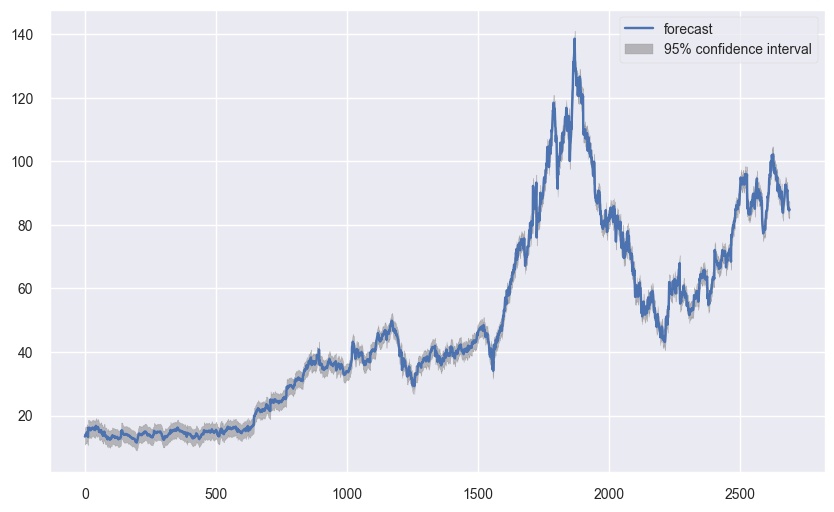

In [100]:
modelohqic = ARIMA(data['Close'].tolist(),order = results['best_order_hqic']).fit()

plt.rcParams.update({'figure.figsize': (10,6)})
fig, ax = plt.subplots()
plot_predict(modelohqic, 2, ax = ax)
plt.show()

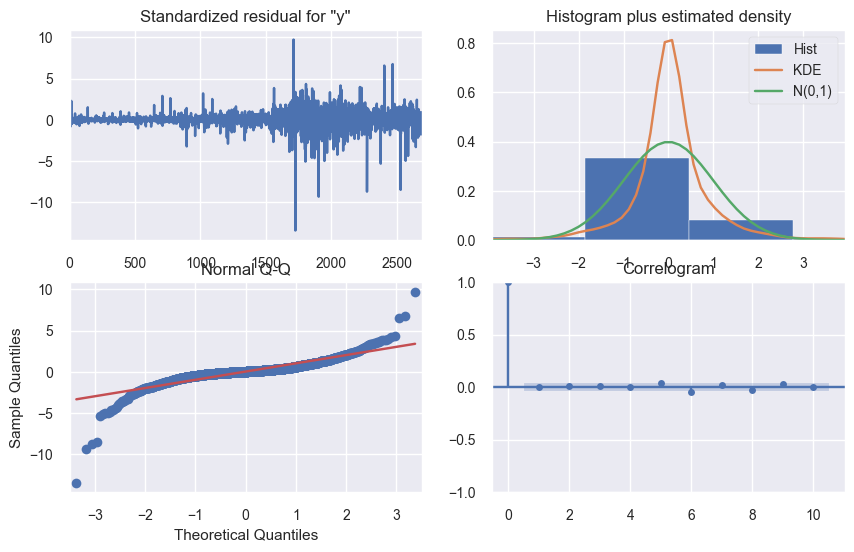

In [101]:
modelohqic.plot_diagnostics()
plt.show()

El primer gráfico muestra los residuos (diferencia entre los valores observados y los valores ajustados) frente a los valores ajustados. Idealmente, los residuos deben estar distribuidos aleatoriamente alrededor de cero y no mostrar ningún patrón sistemático, sin embargo, en la gráfica en bastantes observaciones estos residuos difieren bastante de 0.

El segundo gráfico, histograma, muestra la distribución de los residuos en un histograma. La distribución debería parecerse a una distribución normal, con una forma de campana simétrica alrededor de cero. Un histograma muy asimétrico o sesgado indica que los residuos no están distribuidos normalmente. Tal como se observa en la gráfica, estos residuos no siguen una distribución normal, lo cual es confirmado con el tercer gráfico: Q-Q plot.

En cuanto a la cuarta gráfica, el correlograma, no se observa autocorrelación significativa en los diferentes retardos (lags). En el gráfico, las barras que se extienden más allá de las bandas de confianza indican autocorrelación en esos retardos, lo que sugiere que el modelo puede no estar capturando todas las dependencias en los datos, sin embargo, esto no se presenta para este modelo. 


In [102]:
resid_clean = pd.Series(modelohqic.resid).replace([np.inf, -np.inf], np.nan).dropna()
stat, p = shapiro(resid_clean)

alpha = 0.05
if p > alpha:
    print('Normal')
else:
    print('No normal')

print('Statistics=%.3f, p=%.3f' % (stat, p))

No normal
Statistics=0.777, p=0.000


Esto confirma que los residuos no siguen una distribución normal, tal como se observaba en el histograma y los Q-Q plots.

## $\mathtt{Análisis\;de\;métricas\;por\;criterio}$

In [103]:
pd.DataFrame({
    'Métrica 7 días': raic['Métrica'],
    'AIC - rolling': raic['Días 7'],
    'AIC - no rolling': nraic['Días 7'],
    'BIC - rolling': rbic['Días 7'],
    'BIC - no rolling': nrbic['Días 7'],
    'HQIC - rolling': rhqic['Días 7'],
    'HQIC - no rolling': nrhqic['Días 7'],
})

,Métrica 7 días,AIC - rolling,AIC - no rolling,BIC - rolling,BIC - no rolling,HQIC - rolling,HQIC - no rolling
0,MAPE,1.312539,NaN,1.315387,NaN,15.597257,NaN
1,MAE,1.121135,2.002013,1.124287,1.987144,13.207305,2.021080
2,MSE,1.777947,5.520341,1.862735,5.273568,1024.359477,5.442725
3,RMSE,1.333397,2.349541,1.364820,2.296425,32.005616,2.332965
4,R2,-0.108722,-2.442467,-0.161595,-2.288580,-637.787237,-2.394065


Al evaluar los seis modelos distintos, cada uno utilizando las métricas **MAPE**, **MAE**, **MSE**, **RMSE** y **R²**, y los criterios **AIC**, **BIC** y **HQIC**, se observa lo siguiente: para **MAPE**, el modelo rolling con **AIC** ofrece el valor menor de 1.312539. Para **MAE**, el modelo rolling con **AIC** muestra un valor de 1.121135, que es significativamente más bajo que el MAE de 2.002013 del modelo no rolling con **AIC**, indicando un menor error absoluto medio en el modelo rolling. En términos de **MSE**, el modelo rolling con **AIC** presenta un valor de 1.777947, frente al MSE más alto de 5.520341 del modelo no rolling, lo que sugiere una mejor precisión en el modelo rolling. El **RMSE** sigue la misma tendencia, con el modelo rolling con **AIC** mostrando un valor de 1.333397 frente al 2.349541 del modelo no rolling, reflejando un menor error cuadrático medio. Para **R²**, aunque ambos modelos tienen valores negativos, el modelo rolling con **AIC** (-0.108722) tiene un R² menos negativo en comparación con el modelo no rolling (-2.442467), sugiriendo un rendimiento ligeramente mejor.

En el caso de **BIC**, el modelo rolling con **BIC** tiene un **MAPE** de 1.315387, que es ligeramente peor que el modelo rolling con **AIC**. Para **MAE**, el modelo rolling con **BIC** muestra un valor de 1.124287, que es muy cercano al MAE del modelo rolling con **AIC**. El **MSE** para el modelo rolling con **BIC** es de 1.862735, que es mayor que el **MSE** del modelo rolling con **AIC** pero sigue siendo mejor que el de los modelos no rolling. El **RMSE** para el modelo rolling con **BIC** es de 1.364820, que es mayor que el del modelo rolling con **AIC** pero aún así no es mayor que el de los modelos no rolling. En cuanto al **R²**, el modelo rolling con **BIC** tiene un valor de -0.161595, que es menos negativo que el **R²** del modelo no rolling pero peor que el del modelo rolling con **AIC**.

Para **HQIC**, el modelo rolling con **HQIC** tiene un **MAPE** de 15.597257, que es considerablemente peor que todos los demás modelos. El **MAE** del modelo rolling con **HQIC** es de 13.207305, que también es más alto que los de los modelos **AIC** y **BIC**. El **MSE** es de 1024.359477, el más alto entre todos los modelos, y el **RMSE** de 32.005616 es igualmente el mayor. El **R²** para el modelo rolling con **HQIC** es -637.787237, extremadamente bajo, indicando el peor desempeño entre los modelos.

Es decir, el modelo rolling con **AIC** es el que generalmente muestra el mejor rendimiento en la mayoría de las métricas, seguido por el modelo rolling con **BIC**. Los modelos rolling, en general, tienden a superar a los modelos no rolling en términos de **MAPE**, **MAE**, **MSE** y **RMSE**. Los modelos con **HQIC** no ofrecen un rendimiento competitivo en comparación con los otros criterios.

In [104]:
pd.DataFrame({
    'Métrica 14 días': raic['Métrica'],
    'AIC - rolling': raic['Días 14'],
    'AIC - no rolling': nraic['Días 14'],
    'BIC - rolling': rbic['Días 14'],
    'BIC - no rolling': nrbic['Días 14'],
    'HQIC - rolling': rhqic['Días 14'],
    'HQIC - no rolling': nrhqic['Días 14'],
})

,Métrica 14 días,AIC - rolling,AIC - no rolling,BIC - rolling,BIC - no rolling,HQIC - rolling,HQIC - no rolling
0,MAPE,1.212652,NaN,1.160648,NaN,8.370949,NaN
1,MAE,1.064800,2.519703,1.018572,2.545715,7.122699,2.580556
2,MSE,1.431246,8.349668,1.411075,8.426731,512.780690,8.608524
3,RMSE,1.196347,2.889579,1.187887,2.902883,22.644661,2.934029
4,R2,0.822724,-0.034200,0.825223,-0.043745,-62.513607,-0.066262


Al evaluar los seis modelos distintos utilizando las métricas **MAPE**, **MAE**, **MSE**, **RMSE** y **R²**, y los criterios **AIC**, **BIC** y **HQIC** para un horizonte de 14 días, se observa lo siguiente: para **MAPE**, el modelo rolling con **BIC** ofrece el valor más bajo de 1.160648, que es superior al valor de 1.212652 del modelo rolling con **AIC**. Para **MAE**, el modelo rolling con **BIC** también presenta un valor de 1.018572, significativamente más bajo que el MAE de 1.064800 del modelo rolling con **AIC**, lo que indica una menor desviación media en el modelo rolling con **BIC**. En términos de **MSE**, el modelo rolling con **BIC** muestra un valor de 1.411075, que es ligeramente mejor que el MSE de 1.431246 del modelo rolling con **AIC**, pero ambos valores son mucho mejores que el MSE de 8.349668 de los modelos no rolling. El **RMSE** sigue la misma tendencia, con el modelo rolling con **BIC** mostrando un valor de 1.187887 frente al 1.196347 del modelo rolling con **AIC** y el valor más alto de 2.889579 de los modelos no rolling. Para **R²**, el modelo rolling con **BIC** tiene un valor de 0.825223, que es el más alto entre los modelos analizados y ligeramente mejor que el R² de 0.822724 del modelo rolling con **AIC**. Los modelos no rolling tienen valores de **R²** negativos, lo que indica un rendimiento inferior en comparación con los modelos rolling.

Para **HQIC**, el modelo rolling con **HQIC** muestra un **MAPE** de 8.370949, que es peor que los valores de los modelos **AIC** y **BIC**. El **MAE** del modelo rolling con **HQIC** es de 7.122699, que también es más alto en comparación con los modelos **AIC** y **BIC**. El **MSE** y el **RMSE** son también los más altos en el modelo rolling con **HQIC**, con valores de 512.780690 y 22.644661, respectivamente. El **R²** para el modelo rolling con **HQIC** es de -62.513607, el más bajo entre todos los modelos, lo que indica un rendimiento deficiente.

En resumen, el modelo rolling con **BIC** es el que generalmente muestra el mejor rendimiento en la mayoría de las métricas para un horizonte de 14 días, seguido por el modelo rolling con **AIC**. Los modelos rolling en general tienden a superar a los modelos no rolling en términos de **MAPE**, **MAE**, **MSE**, **RMSE** y **R²**. Los modelos con **HQIC** no ofrecen un rendimiento competitivo en comparación con los otros criterios.

In [105]:
pd.DataFrame({
    'Métrica 21 días': raic['Métrica'],
    'AIC - rolling': raic['Días 21'],
    'AIC - no rolling': nraic['Días 21'],
    'BIC - rolling': rbic['Días 21'],
    'BIC - no rolling': nrbic['Días 21'],
    'HQIC - rolling': rhqic['Días 21'],
    'HQIC - no rolling': nrhqic['Días 21'],
})

,Métrica 21 días,AIC - rolling,AIC - no rolling,BIC - rolling,BIC - no rolling,HQIC - rolling,HQIC - no rolling
0,MAPE,1.146243,NaN,1.110016,NaN,5.924117,NaN
1,MAE,1.014617,2.705316,0.982382,2.730000,5.058275,2.752778
2,MSE,1.402353,9.062227,1.399503,9.153116,342.326566,9.266348
3,RMSE,1.184210,3.010353,1.183006,3.025412,18.502069,3.044068
4,R2,0.802789,-0.274406,0.803190,-0.287187,-47.140810,-0.303111


Al evaluar los seis modelos distintos utilizando las métricas **MAPE**, **MAE**, **MSE**, **RMSE** y **R²**, y los criterios **AIC**, **BIC** y **HQIC** para un horizonte de 21 días, se observa lo siguiente: para **MAPE**, el modelo rolling con **BIC** presenta el valor más bajo de 1.110016, superando al modelo rolling con **AIC** que muestra un MAPE de 1.146243. En cuanto a **MAE**, el modelo rolling con **BIC** tiene un valor de 0.982382, que es notablemente mejor que el MAE de 1.014617 del modelo rolling con **AIC**, y también supera a los modelos no rolling que presentan valores más altos. Para **MSE**, el modelo rolling con **BIC** muestra un valor de 1.399503, que es ligeramente mejor que el MSE de 1.402353 del modelo rolling con **AIC**, y significativamente mejor que los valores más altos de los modelos no rolling. El **RMSE** sigue una tendencia similar, con el modelo rolling con **BIC** presentando un valor de 1.183006 frente al 1.184210 del modelo rolling con **AIC**, y superando al valor más alto de 3.010353 de los modelos no rolling. En términos de **R²**, el modelo rolling con **BIC** tiene un valor de 0.803190, que es el más alto entre todos los modelos, en comparación con el R² de 0.802789 del modelo rolling con **AIC** y los valores negativos de los modelos no rolling.

Para **HQIC**, el modelo rolling con **HQIC** muestra un **MAPE** de 5.924117, que es peor que los valores de los modelos **AIC** y **BIC**. El **MAE** del modelo rolling con **HQIC** es de 5.058275, lo cual también es superior a los valores de los modelos **AIC** y **BIC**. El **MSE** y el **RMSE** en el modelo rolling con **HQIC** son de 342.326566 y 18.502069, respectivamente, ambos significativamente más altos que los valores de los modelos **AIC** y **BIC**. El **R²** para el modelo rolling con **HQIC** es de -47.140810, el más bajo entre todos los modelos, indicando el peor desempeño.

En resumen, el modelo rolling con **BIC** demuestra el mejor rendimiento en la mayoría de las métricas para un horizonte de 21 días, seguido por el modelo rolling con **AIC**. Los modelos rolling generalmente superan a los modelos no rolling en términos de **MAPE**, **MAE**, **MSE**, **RMSE** y **R²**. Los modelos con **HQIC** no son competitivos en comparación con los otros criterios.

In [106]:
pd.DataFrame({
    'Métrica 28 días': raic['Métrica'],
    'AIC - rolling': raic['Días 28'],
    'AIC - no rolling': nraic['Días 28'],
    'BIC - rolling': rbic['Días 28'],
    'BIC - no rolling': nrbic['Días 28'],
    'HQIC - rolling': rhqic['Días 28'],
    'HQIC - no rolling': nrhqic['Días 28'],
})

,Métrica 28 días,AIC - rolling,AIC - no rolling,BIC - rolling,BIC - no rolling,HQIC - rolling,HQIC - no rolling
0,MAPE,1.087074,NaN,1.059167,NaN,4.669373,NaN
1,MAE,0.955439,2.618068,0.930715,2.624643,3.987300,2.636670
2,MSE,1.324720,8.271219,1.317260,8.282847,257.006110,8.345857
3,RMSE,1.150965,2.875973,1.147719,2.877993,16.031410,2.888920
4,R2,0.835196,-0.028992,0.836125,-0.030439,-30.973186,-0.038277


Al analizar los seis modelos distintos para un horizonte de 28 días utilizando las métricas **MAPE**, **MAE**, **MSE**, **RMSE** y **R²**, y los criterios **AIC**, **BIC** y **HQIC**, se observa lo siguiente: para **MAPE**, el modelo rolling con **BIC** presenta el valor más bajo de 1.059167, superando al modelo rolling con **AIC**, que tiene un MAPE de 1.087074. En cuanto a **MAE**, el modelo rolling con **BIC** muestra un valor de 0.930715, que es el más bajo entre todos los modelos, incluyendo los modelos no rolling, que tienen valores más altos. El **MSE** para el modelo rolling con **BIC** es de 1.317260, ligeramente mejor que el MSE de 1.324720 del modelo rolling con **AIC**, y notablemente mejor que los valores más altos de los modelos no rolling. El **RMSE** sigue la misma tendencia, con el modelo rolling con **BIC** mostrando un valor de 1.147719 frente al 1.150965 del modelo rolling con **AIC**, y superando al valor más alto de 2.875973 de los modelos no rolling. En términos de **R²**, el modelo rolling con **BIC** tiene un valor de 0.836125, que es el más alto entre todos los modelos, en comparación con el R² de 0.835196 del modelo rolling con **AIC** y los valores negativos de los modelos no rolling.

Para **HQIC**, el modelo rolling con **HQIC** muestra un **MAPE** de 4.669373, que es peor que los valores de los modelos **AIC** y **BIC**. El **MAE** del modelo rolling con **HQIC** es de 3.987300, también superior a los valores de los modelos **AIC** y **BIC**. El **MSE** y el **RMSE** para el modelo rolling con **HQIC** son de 257.006110 y 16.031410, respectivamente, ambos considerablemente más altos que los valores de los modelos **AIC** y **BIC**. El **R²** para el modelo rolling con **HQIC** es de -30.973186, el más bajo entre todos los modelos, indicando el peor desempeño.

En conclusión, el modelo rolling con **BIC** muestra el mejor rendimiento en la mayoría de las métricas para un horizonte de 28 días, seguido por el modelo rolling con **AIC**. Los modelos rolling en general superan a los modelos no rolling en términos de **MAPE**, **MAE**, **MSE**, **RMSE** y **R²**. Los modelos con **HQIC** no ofrecen un rendimiento competitivo en comparación con los otros criterios.

### $\mathtt{Conclusiones}$

En conclusión general, los modelos rolling con **AIC** y **BIC** son consistentemente los mejores en comparación con los modelos no rolling, con una ligera ventaja del modelo rolling con **BIC** para horizontes más largos. Los modelos con **HQIC** no muestran un rendimiento competitivo en comparación con los modelos con **AIC** y **BIC** en los diferentes horizontes de predicción.